Dissertation
    
# **Notebook 3B: Cluster Ascending**
    
This notebook will cluster identified  LSOAs, to further explore the sub-types of gentrification using K-means clustering.

***

In [1]:
# Load packages

import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import geopandas as gpd
import contextily as ctx
from shapely.geometry import Point
from matplotlib_scalebar.scalebar import ScaleBar

In [2]:
# Look at working dir

print("The working directory is " + os.getcwd())

The working directory is /home/jovyan/work/OneDrive/UCL/Dissertation/Notebooks V3


In [3]:
shapefiles = os.path.join("Shapefiles")

profiles = os.path.join("LSOA Profiles")

clean = os.path.join("Cleaned data")

In [4]:
plt.rcParams['axes.spines.left'] = False
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.bottom'] = False

# 1. Load in data

In [5]:
# Ascending

level2 = pd.read_csv(os.path.join(clean, "gencluster1.csv"), encoding="unicode_escape")

In [6]:
# Census 

census_2001 = pd.read_csv(os.path.join(profiles, "census_2001_profile.csv"))
census_2011 = pd.read_csv(os.path.join(profiles, "census_2011_profile.csv"))

# 2. Wrangle NSSEC

In [7]:
# Filter 

census_2001_nssec = census_2001[['LSOA01CD','1. Higher managerial, administrative and professional occupations', '2. Lower managerial, administrative and professional occupations', '3. Intermediate occupations',
                     '4. Small employers and own account workers', '5. Lower supervisory and technical occupations', '6. Semi-routine occupations', '7. Routine occupations' ]]

# Save for geonconvert
census_2001_nssec.to_csv(os.path.join(clean, "census_2001_nssec_before_geoconvert.csv"))


In [8]:
# Read in geoconverted values

census_2001_nssec_converted = pd.read_csv(os.path.join(clean, "geoconvert", "nssecallcatgeoconverted.csv"))
income_2001_converted = pd.read_csv(os.path.join(clean, "geoconvert", "incomegeoconverted.csv"))

In [9]:
# Merge 

variables_2001 = pd.merge(census_2001_nssec_converted, income_2001_converted, on="LSOA11CD")

In [10]:
# Check all LSOAs are there 

if len(variables_2001) == len(census_2011):
    print("All is good")


In [11]:
# Add in 2001

variables_2001 = variables_2001.rename(columns={c: c+'_2001' for c in variables_2001.columns if c not in ['LSOA11CD', "Median_income_2001"]})


In [12]:
# Filter 2011

census_2011_nssec = census_2011[['LSOA11CD','1. Higher managerial, administrative and professional occupations', '2. Lower managerial, administrative and professional occupations', '3. Intermediate occupations',
                     '4. Small employers and own account workers', '5. Lower supervisory and technical occupations', '6. Semi-routine occupations', '7. Routine occupations']]

In [13]:
# Add in income

census_2011_nssec["Median_income"] = census_2011["Totalweeklyincome(£)"] * 52

/opt/conda/envs/sds2021/lib/python3.9/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


In [14]:
# Rename
census_2011_nssec = census_2011_nssec.rename(columns={
    '1. Higher managerial, administrative and professional occupations':"NS-SEC1",
 '2. Lower managerial, administrative and professional occupations':"NS-SEC2",
 '3. Intermediate occupations':"NS-SEC3",
 '4. Small employers and own account workers':"NS-SEC4",
 '5. Lower supervisory and technical occupations':"NS-SEC5",
 '6. Semi-routine occupations':"NS-SEC6",
 '7. Routine occupations':"NS-SEC7"
})

# Add in 2011

variables_2011 = census_2011_nssec.rename(columns={c: c+'_2011' for c in census_2011_nssec.columns if c not in ['LSOA11CD', "Median_income_2011"]})


In [15]:
all_demo_vars = pd.merge(variables_2011, variables_2001, on="LSOA11CD")

In [16]:
asc_lsoa = level2[["LSOA11CD"]]

In [17]:
demo_vars = pd.merge(asc_lsoa, all_demo_vars, on="LSOA11CD")

In [18]:
def percent_change(before, after):
    x = ((before-after)/before)*100
    return(x)

In [19]:
demo_vars["NSSEC1_CHG"] = percent_change(demo_vars["NS-SEC1_2001"], demo_vars["NS-SEC1_2011"])
demo_vars["NSSEC2_CHG"] = percent_change(demo_vars["NS-SEC2_2001"], demo_vars["NS-SEC2_2011"])
demo_vars["NSSEC3_CHG"] = percent_change(demo_vars["NS-SEC3_2001"], demo_vars["NS-SEC3_2011"])
demo_vars["NSSEC4_CHG"] = percent_change(demo_vars["NS-SEC4_2001"], demo_vars["NS-SEC4_2011"])
demo_vars["NSSEC5_CHG"] = percent_change(demo_vars["NS-SEC5_2001"], demo_vars["NS-SEC5_2011"])
demo_vars["NSSEC6_CHG"] = percent_change(demo_vars["NS-SEC6_2001"], demo_vars["NS-SEC6_2011"])
demo_vars["NSSEC7_CHG"] = percent_change(demo_vars["NS-SEC7_2001"], demo_vars["NS-SEC7_2011"])
demo_vars["INC_CHG"] = percent_change(demo_vars["Median_income_2001"], demo_vars["Median_income_2011"])

In [20]:
demo_vars_final = demo_vars[['LSOA11CD','NSSEC1_CHG', 'NSSEC2_CHG', 'NSSEC3_CHG',
       'NSSEC4_CHG', 'NSSEC5_CHG', 'NSSEC6_CHG', 'NSSEC7_CHG', 'INC_CHG', 'Median_income_2001']]

# 2. Housing Domain

2.1 2001

In [21]:
# Subset

census_2001_house = census_2001[["LSOA01CD",'All categories: Tenure',
 'Owned outright',
 'Owned with a mortgage or loan',
 'Shared ownership',
 'Rented from council(local authority)',
 'Rented from a housing association/registered social landlord',
 'Rented from a private landlord or letting agency']]

In [22]:
census_2001_house["OWNED_2001"] = census_2001_house[['Owned outright','Owned with a mortgage or loan','Shared ownership']].sum(axis=1)
census_2001_house["SOC_RENT_2001"] = census_2001_house[['Rented from council(local authority)','Rented from a housing association/registered social landlord']].sum(axis=1)
census_2001_house["PRIV_RENT_2001"] = census_2001_house[["Rented from a private landlord or letting agency"]].sum(axis=1)

In [23]:
census_2001_house = census_2001_house[["LSOA01CD","OWNED_2001", "SOC_RENT_2001", "PRIV_RENT_2001"]]

In [24]:
census_2001_house.to_csv(os.path.join(clean, "census_2001_house_before_geoconvert.csv"))

In [25]:
# Read in geoconverted

census_2001_tenure_converted = pd.read_csv(os.path.join(clean, "geoconvert", "tenuregeoconverted.csv"))
house_prices_2001_converted = pd.read_csv(os.path.join(clean, "geoconvert", "housegeoconverted.csv"))

In [26]:
census_2001_house = pd.merge(census_2001_tenure_converted,house_prices_2001_converted, on="LSOA11CD" )

2.2 2011

In [27]:
# Read in house prices

house_price = pd.read_csv(os.path.join(clean, "ranking_vars.csv"))
house_price = house_price[["LSOA11CD","Mean_house_prices_2011"]]

In [28]:
# Subset

census_2011_house = census_2011[["LSOA11CD",'Owned', 'Social rented', 'Private rented']]

# Tidy names

census_2011_house = census_2011_house.rename(columns={"Owned":"OWNED_2011", "Social rented":"SOC_RENT_2011", "Private rented":"PRIV_RENT_2011"})

2.3 Merge

In [29]:
urban_vars = pd.merge(census_2001_house, census_2011_house, on="LSOA11CD")
urban_vars = pd.merge(urban_vars, house_price, on="LSOA11CD")


2.4 Calculate

In [30]:
urban_vars["OWNED_CHG"] = percent_change(urban_vars["OWNED_2001"], urban_vars["OWNED_2011"])
urban_vars["PRIV_REN_CHG"] = percent_change(urban_vars["PRIV_RENT_2001"], urban_vars["PRIV_RENT_2011"])
urban_vars["SOC_REN_CHG"] = percent_change(urban_vars["SOC_RENT_2001"], urban_vars["SOC_RENT_2011"])
urban_vars["HOUSE_PRICE_CHG"] = percent_change(urban_vars["Mean_house_prices_2001"], urban_vars["Mean_house_prices_2011"])

2.5 Tidy

In [31]:
urban_vars.columns

Index(['LSOA11CD', 'OWNED_2001', 'SOC_RENT_2001', 'PRIV_RENT_2001',
       'Mean_house_prices_2001', 'OWNED_2011', 'SOC_RENT_2011',
       'PRIV_RENT_2011', 'Mean_house_prices_2011', 'OWNED_CHG', 'PRIV_REN_CHG',
       'SOC_REN_CHG', 'HOUSE_PRICE_CHG'],
      dtype='object')

In [32]:
urban_vars_final = urban_vars[['LSOA11CD', 'OWNED_CHG', 'PRIV_REN_CHG',
       'SOC_REN_CHG', 'HOUSE_PRICE_CHG', 'Mean_house_prices_2001']]

# 3. Merge

In [33]:
all_vars = pd.merge(urban_vars_final, demo_vars_final, on="LSOA11CD")

In [34]:
level2 = level2[["LSOA11CD", "Level2Cat"]]
level2_filt = level2[level2["Level2Cat"]=="cluster3"]

In [35]:
# Merge

cluster_2 = pd.merge(level2_filt, all_vars, on="LSOA11CD", how="left")

In [36]:
cluster_2 = cluster_2.reset_index()

In [37]:
cluster_2 = cluster_2.set_index("LSOA11CD")
cluster_2 = cluster_2.drop(columns=["Level2Cat", "index"])

In [38]:
cluster_2.replace([np.inf, -np.inf], np.nan, inplace=True)
cluster_2=cluster_2.fillna(0)

# 4. Cluster

No handles with labels found to put in legend.


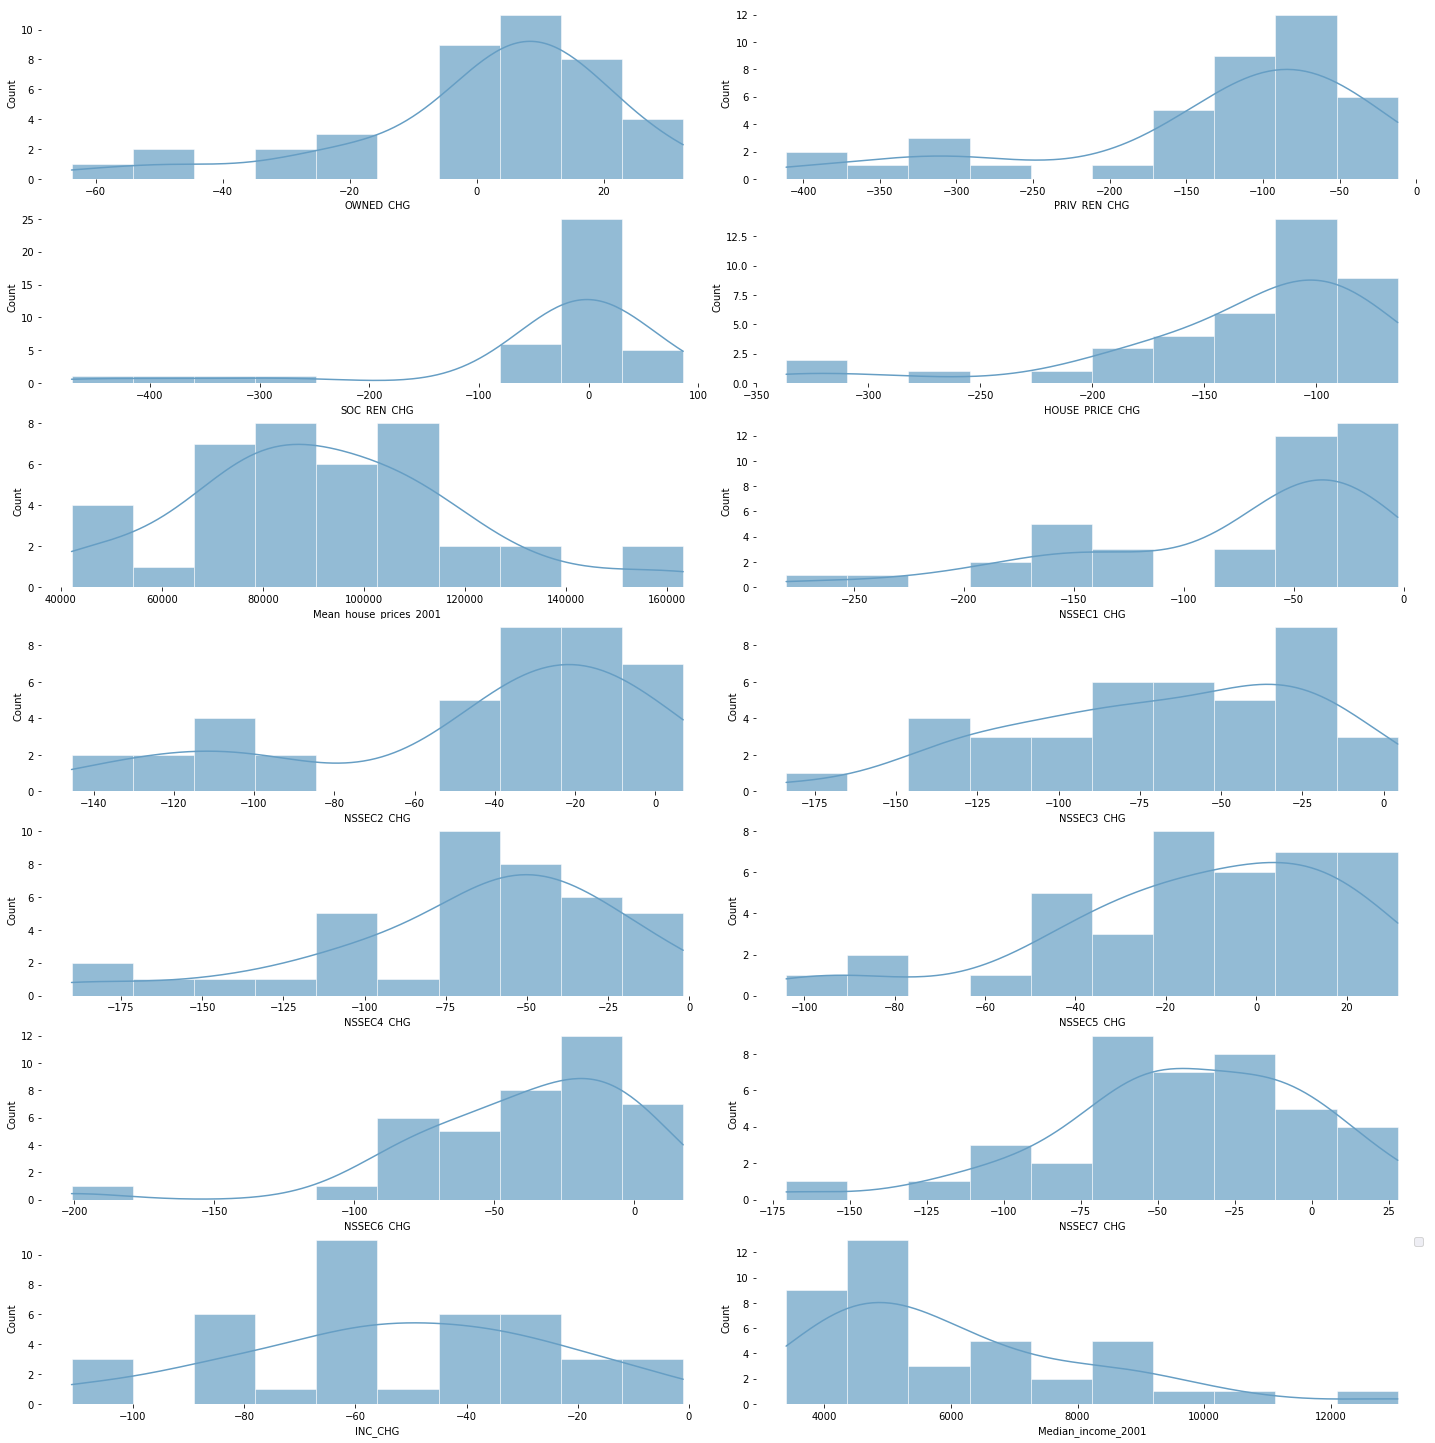

In [39]:
# Look at underlying dist

fig, axs = plt.subplots(nrows=7, ncols=2, figsize=(20,20))
fig.tight_layout()
sns.set(style="whitegrid")
sns.set(font_scale = 1)

sns.histplot(ax=axs[0,0],data=cluster_2, x="OWNED_CHG", kde=True, legend = True, color="#669EC4", linewidth=0.5, alpha=0.7, bins=10)
sns.histplot(ax=axs[0,1],data=cluster_2, x="PRIV_REN_CHG", kde=True, legend = True, color="#669EC4", linewidth=0.5, alpha=0.7, bins=10)

sns.histplot(ax=axs[1,0],data=cluster_2, x="SOC_REN_CHG", kde=True, legend = True, color="#669EC4", linewidth=0.5, alpha=0.7, bins=10)
sns.histplot(ax=axs[1,1],data=cluster_2, x="HOUSE_PRICE_CHG", kde=True, legend = True, color="#669EC4", linewidth=0.5, alpha=0.7, bins=10)

sns.histplot(ax=axs[2, 0],data=cluster_2, x="Mean_house_prices_2001", kde=True, legend = True, color="#669EC4", linewidth=0.5, alpha=0.7, bins=10)
sns.histplot(ax=axs[2,1],data=cluster_2, x="NSSEC1_CHG", kde=True, legend = True, color="#669EC4", linewidth=0.5, alpha=0.7, bins=10)

sns.histplot(ax=axs[3,0],data=cluster_2, x="NSSEC2_CHG", kde=True, legend = True, color="#669EC4", linewidth=0.5, alpha=0.7, bins=10)
sns.histplot(ax=axs[3,1],data=cluster_2, x="NSSEC3_CHG", kde=True, legend = True, color="#669EC4", linewidth=0.5, alpha=0.7, bins=10)

sns.histplot(ax=axs[4,0],data=cluster_2, x="NSSEC4_CHG", kde=True, legend = True, color="#669EC4", linewidth=0.5, alpha=0.7, bins=10)
sns.histplot(ax=axs[4,1],data=cluster_2, x="NSSEC5_CHG", kde=True, legend = True, color="#669EC4", linewidth=0.5, alpha=0.7, bins=10)

sns.histplot(ax=axs[5,0],data=cluster_2, x="NSSEC6_CHG", kde=True, legend = True, color="#669EC4", linewidth=0.5, alpha=0.7, bins=10)
sns.histplot(ax=axs[5,1],data=cluster_2, x="NSSEC7_CHG", kde=True, legend = True, color="#669EC4", linewidth=0.5, alpha=0.7, bins=10)

sns.histplot(ax=axs[6,0],data=cluster_2, x="INC_CHG", kde=True, legend = True, color="#669EC4", linewidth=0.5, alpha=0.7, bins=10)
sns.histplot(ax=axs[6,1],data=cluster_2, x="Median_income_2001", kde=True, legend = True, color="#669EC4", linewidth=0.5, alpha=0.7, bins=10)
   
plt.legend() 

plt.savefig(os.path.join("Figures", 'hist_gent_cluster2_.png'), transparent=True, dpi=300)

plt.show()

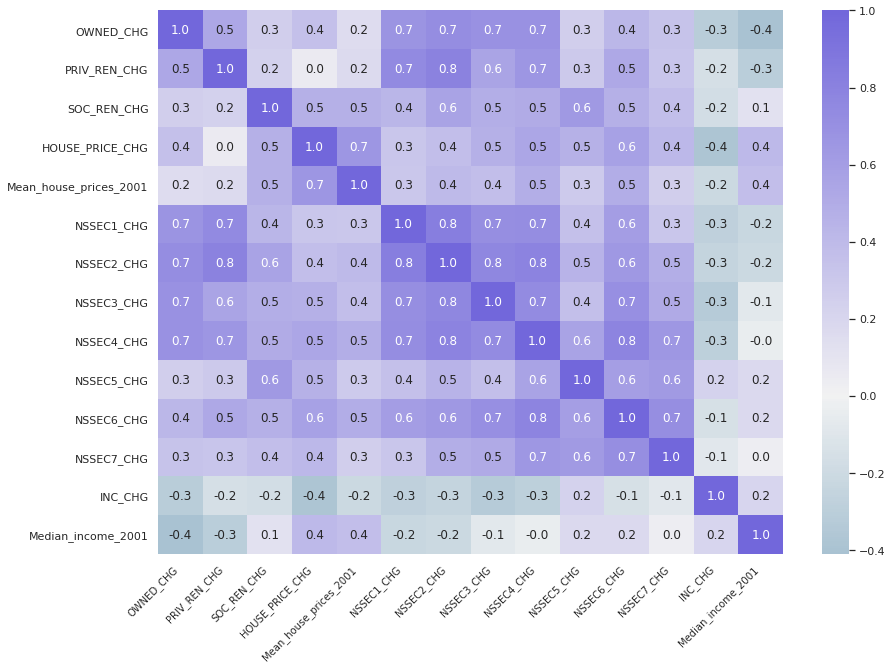

In [40]:
# check for multi-collinearity between variables

fig, ax = plt.subplots()
fig.set_size_inches(14, 10)
cmap = sns.diverging_palette(235.5, 268.1, as_cmap=True)
#cmap = sns.diverging_palette(204,252, as_cmap=True)

ax=sns.heatmap(cluster_2.corr(), cmap=cmap, center=0, annot=True, fmt=".1f")
plt.xticks(rotation=45,ha='right',fontsize=10)

plt.savefig(os.path.join("Figures", 'heat_gent_cluster2.png'), transparent=False, dpi=300)

# 4.2 Transform

4.2.1 No Transform

In [41]:
cluster_2_noTrans = cluster_2[:]

In [42]:
# applying cube root transformation to data variables

cluster_2_cubeRoot = np.cbrt(cluster_2)

No handles with labels found to put in legend.


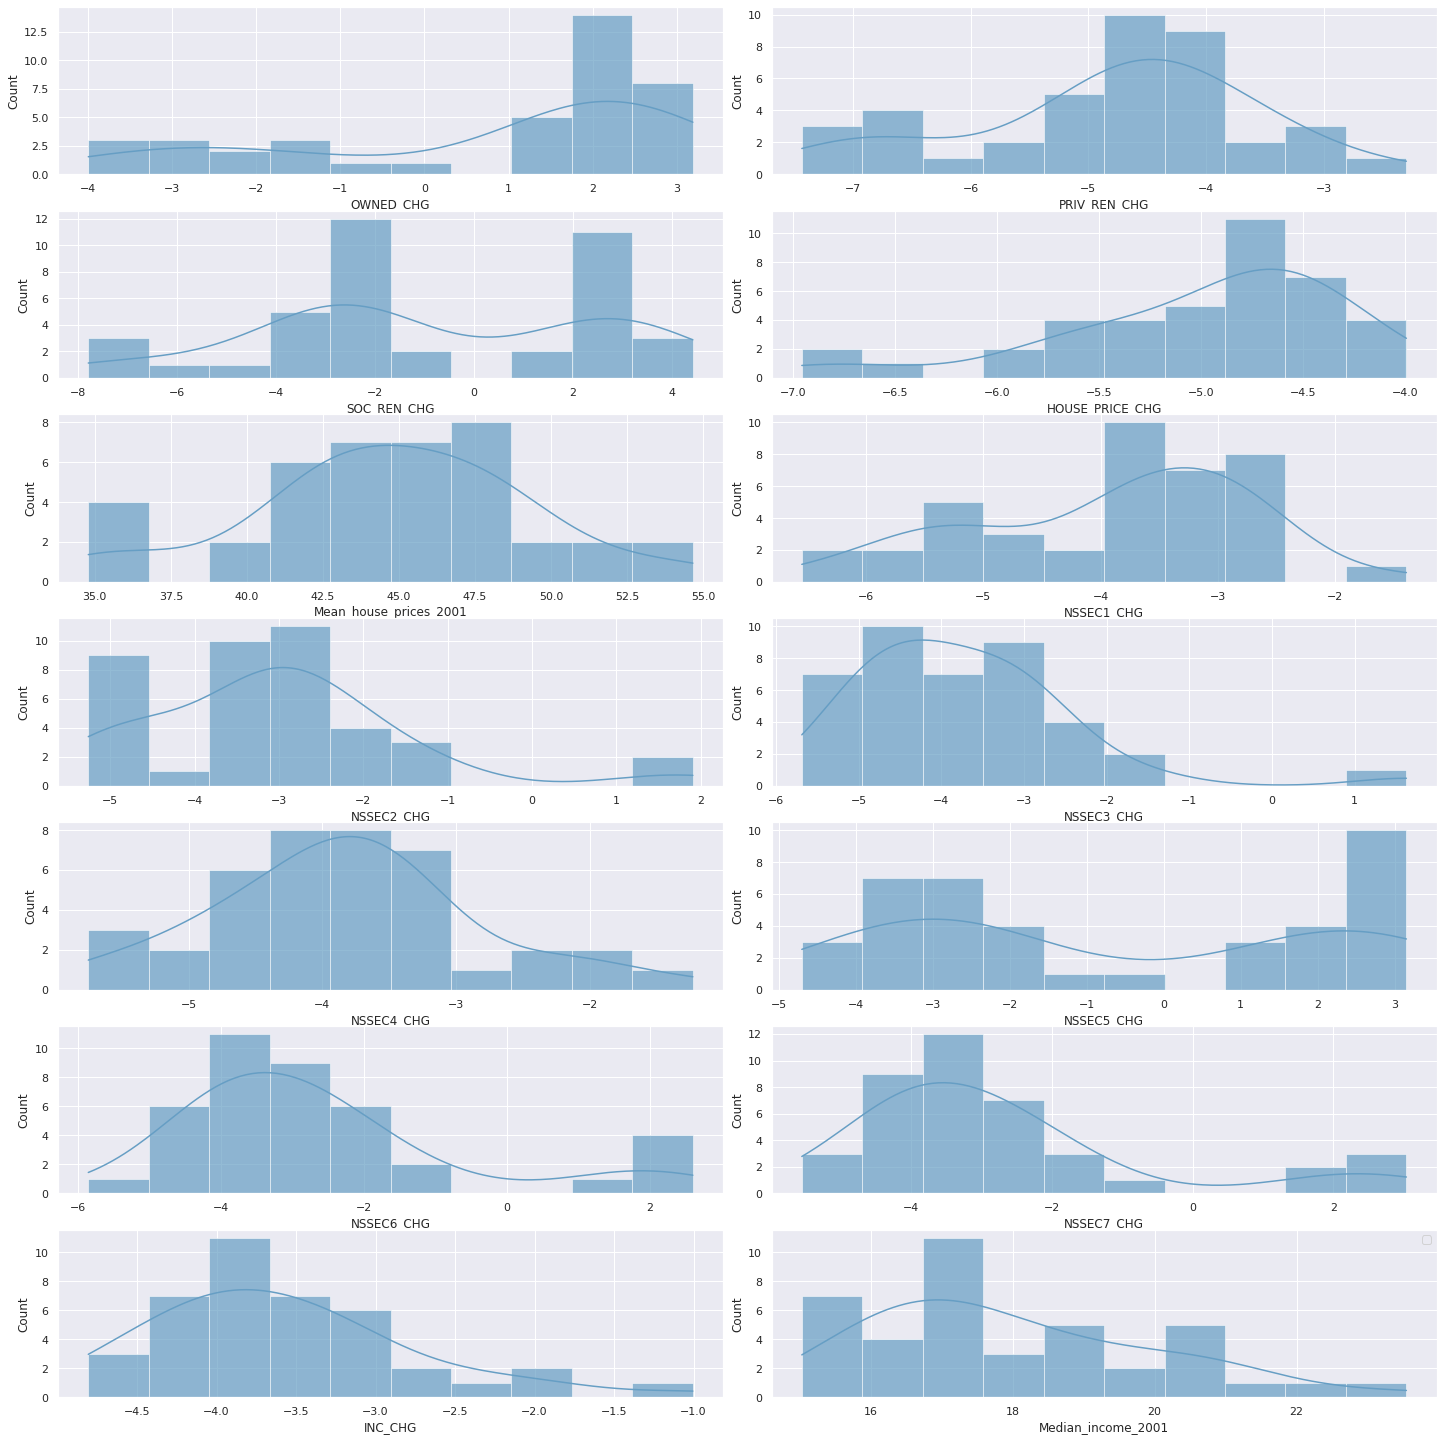

In [43]:
# Look at underlying dist

fig, axs = plt.subplots(nrows=7, ncols=2, figsize=(20,20))
fig.tight_layout()
sns.set(style="whitegrid")
sns.set(font_scale = 1)

sns.histplot(ax=axs[0,0],data=cluster_2_cubeRoot, x="OWNED_CHG", kde=True, legend = True, color="#669EC4", linewidth=0.5, alpha=0.7, bins=10)
sns.histplot(ax=axs[0,1],data=cluster_2_cubeRoot, x="PRIV_REN_CHG", kde=True, legend = True, color="#669EC4", linewidth=0.5, alpha=0.7, bins=10)

sns.histplot(ax=axs[1,0],data=cluster_2_cubeRoot, x="SOC_REN_CHG", kde=True, legend = True, color="#669EC4", linewidth=0.5, alpha=0.7, bins=10)
sns.histplot(ax=axs[1,1],data=cluster_2_cubeRoot, x="HOUSE_PRICE_CHG", kde=True, legend = True, color="#669EC4", linewidth=0.5, alpha=0.7, bins=10)

sns.histplot(ax=axs[2, 0],data=cluster_2_cubeRoot, x="Mean_house_prices_2001", kde=True, legend = True, color="#669EC4", linewidth=0.5, alpha=0.7, bins=10)
sns.histplot(ax=axs[2,1],data=cluster_2_cubeRoot, x="NSSEC1_CHG", kde=True, legend = True, color="#669EC4", linewidth=0.5, alpha=0.7, bins=10)

sns.histplot(ax=axs[3,0],data=cluster_2_cubeRoot, x="NSSEC2_CHG", kde=True, legend = True, color="#669EC4", linewidth=0.5, alpha=0.7, bins=10)
sns.histplot(ax=axs[3,1],data=cluster_2_cubeRoot, x="NSSEC3_CHG", kde=True, legend = True, color="#669EC4", linewidth=0.5, alpha=0.7, bins=10)

sns.histplot(ax=axs[4,0],data=cluster_2_cubeRoot, x="NSSEC4_CHG", kde=True, legend = True, color="#669EC4", linewidth=0.5, alpha=0.7, bins=10)
sns.histplot(ax=axs[4,1],data=cluster_2_cubeRoot, x="NSSEC5_CHG", kde=True, legend = True, color="#669EC4", linewidth=0.5, alpha=0.7, bins=10)

sns.histplot(ax=axs[5,0],data=cluster_2_cubeRoot, x="NSSEC6_CHG", kde=True, legend = True, color="#669EC4", linewidth=0.5, alpha=0.7, bins=10)
sns.histplot(ax=axs[5,1],data=cluster_2_cubeRoot, x="NSSEC7_CHG", kde=True, legend = True, color="#669EC4", linewidth=0.5, alpha=0.7, bins=10)

sns.histplot(ax=axs[6,0],data=cluster_2_cubeRoot, x="INC_CHG", kde=True, legend = True, color="#669EC4", linewidth=0.5, alpha=0.7, bins=10)
sns.histplot(ax=axs[6,1],data=cluster_2_cubeRoot, x="Median_income_2001", kde=True, legend = True, color="#669EC4", linewidth=0.5, alpha=0.7, bins=10)

   
plt.legend() 

plt.savefig(os.path.join("Figures", 'hist_gcluster_2_cubeRoot.png'), transparent=True, dpi=300)

plt.show()

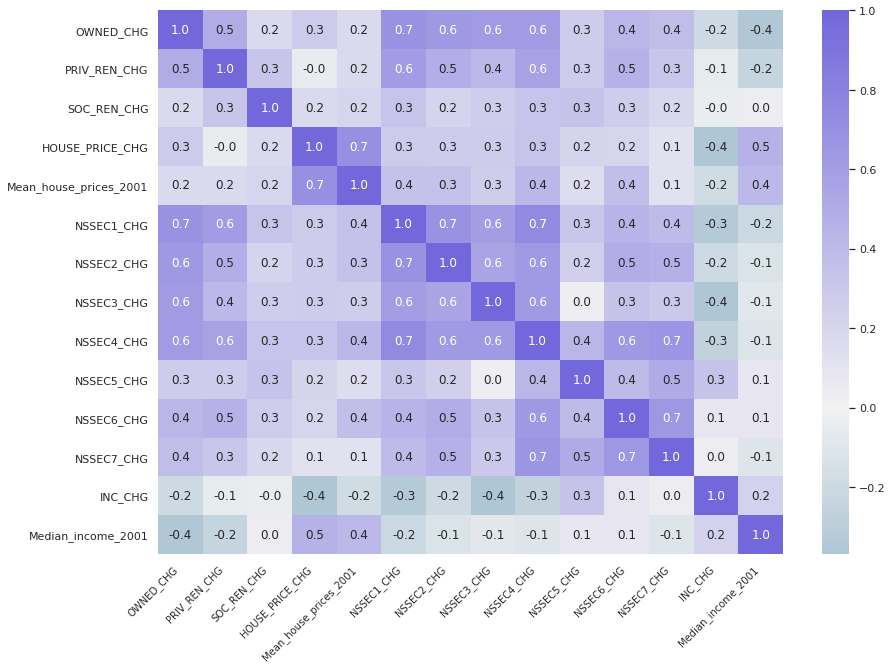

In [44]:
# check for multi-collinearity between variables

fig, ax = plt.subplots()
fig.set_size_inches(14, 10)
cmap = sns.diverging_palette(235.5, 268.1, as_cmap=True)

ax=sns.heatmap(cluster_2_cubeRoot.corr(), cmap=cmap, center=0, annot=True, fmt=".1f")
plt.xticks(rotation=45,ha='right',fontsize=10)

plt.savefig(os.path.join("Figures", 'heat_cluster_2_cubeRoot.png'), transparent=False, dpi=300)

In [45]:
# applying the Yeo-Johnson transformation to data variables

from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaled = scaler.fit_transform(cluster_2)
pt = PowerTransformer(method='yeo-johnson', standardize=False)
pt.fit(cluster_2)

cluster_2_yeoJohnson = pt.transform(scaled)


/opt/conda/envs/sds2021/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:3237: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


In [46]:
# Make into df

cluster_2_yeoJohnson = pd.DataFrame(cluster_2_yeoJohnson, index = cluster_2.index, columns = cluster_2.columns)

No handles with labels found to put in legend.


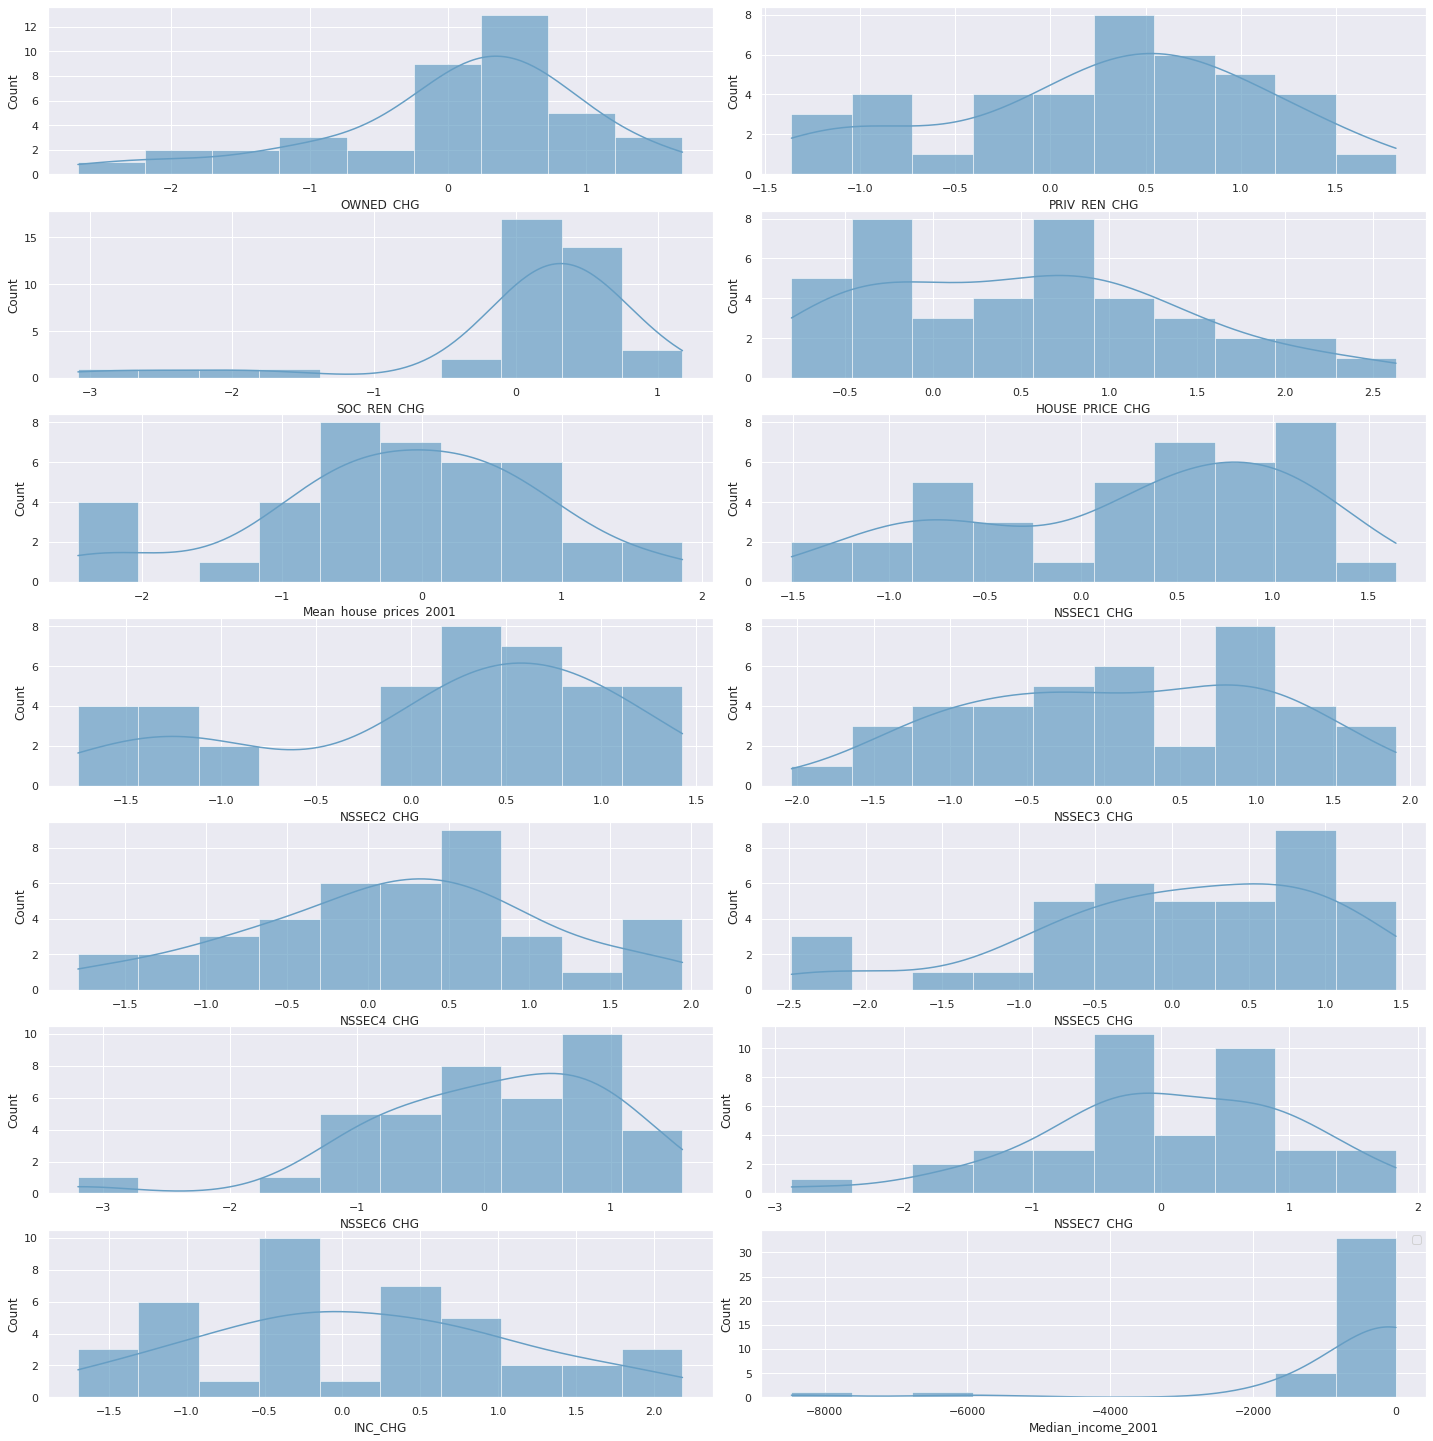

In [47]:
fig, axs = plt.subplots(nrows=7, ncols=2, figsize=(20,20))

sns.set(style="whitegrid")
sns.set(font_scale = 1)
fig.tight_layout()

sns.histplot(ax=axs[0,0],data=cluster_2_yeoJohnson, x="OWNED_CHG", kde=True, legend = True, color="#669EC4", linewidth=0.5, alpha=0.7)
sns.histplot(ax=axs[0,1],data=cluster_2_yeoJohnson, x="PRIV_REN_CHG", kde=True, legend = True, color="#669EC4", linewidth=0.5, alpha=0.7, bins=10)

sns.histplot(ax=axs[1,0],data=cluster_2_yeoJohnson, x="SOC_REN_CHG", kde=True, legend = True, color="#669EC4", linewidth=0.5, alpha=0.7, bins=10)
sns.histplot(ax=axs[1,1],data=cluster_2_yeoJohnson, x="HOUSE_PRICE_CHG", kde=True, legend = True, color="#669EC4", linewidth=0.5, alpha=0.7, bins=10)

sns.histplot(ax=axs[2, 0],data=cluster_2_yeoJohnson, x="Mean_house_prices_2001", kde=True, legend = True, color="#669EC4", linewidth=0.5, alpha=0.7, bins=10)
sns.histplot(ax=axs[2,1],data=cluster_2_yeoJohnson, x="NSSEC1_CHG", kde=True, legend = True, color="#669EC4", linewidth=0.5, alpha=0.7, bins=10)

sns.histplot(ax=axs[3,0],data=cluster_2_yeoJohnson, x="NSSEC2_CHG", kde=True, legend = True, color="#669EC4", linewidth=0.5, alpha=0.7, bins=10)
sns.histplot(ax=axs[3,1],data=cluster_2_yeoJohnson, x="NSSEC3_CHG", kde=True, legend = True, color="#669EC4", linewidth=0.5, alpha=0.7, bins=10)

sns.histplot(ax=axs[4,0],data=cluster_2_yeoJohnson, x="NSSEC4_CHG", kde=True, legend = True, color="#669EC4", linewidth=0.5, alpha=0.7, bins=10)
sns.histplot(ax=axs[4,1],data=cluster_2_yeoJohnson, x="NSSEC5_CHG", kde=True, legend = True, color="#669EC4", linewidth=0.5, alpha=0.7, bins=10)

sns.histplot(ax=axs[5,0],data=cluster_2_yeoJohnson, x="NSSEC6_CHG", kde=True, legend = True, color="#669EC4", linewidth=0.5, alpha=0.7, bins=10)
sns.histplot(ax=axs[5,1],data=cluster_2_yeoJohnson, x="NSSEC7_CHG", kde=True, legend = True, color="#669EC4", linewidth=0.5, alpha=0.7, bins=10)

sns.histplot(ax=axs[6,0],data=cluster_2_yeoJohnson, x="INC_CHG", kde=True, legend = True, color="#669EC4", linewidth=0.5, alpha=0.7, bins=10)
sns.histplot(ax=axs[6,1],data=cluster_2_yeoJohnson, x="Median_income_2001", kde=True, legend = True, color="#669EC4", linewidth=0.5, alpha=0.7, bins=10)

plt.legend() 

plt.savefig(os.path.join("Figures", 'hist_gent_cluster2_yeo.png'), transparent=True, dpi=300)

plt.show()

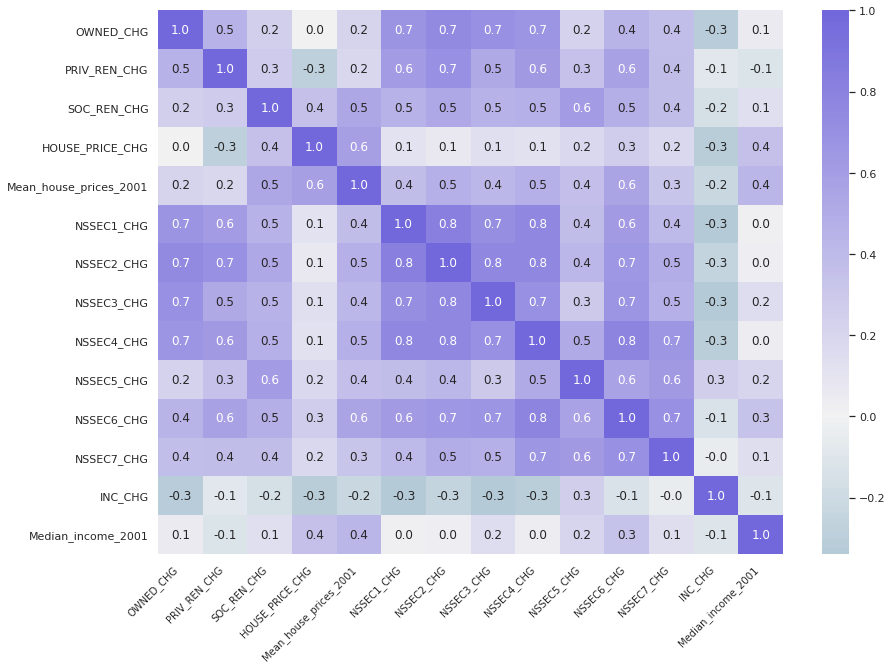

In [48]:
# check for multi-collinearity between variables

fig, ax = plt.subplots()
fig.set_size_inches(14, 10)
cmap = sns.diverging_palette(235.5, 268.1, as_cmap=True)

ax=sns.heatmap(cluster_2_yeoJohnson.corr(), cmap=cmap, center=0, annot=True, fmt=".1f")
plt.xticks(rotation=45,ha='right',fontsize=10)

plt.savefig(os.path.join("Figures", 'heat_cluster_2_yeoJohnson.png'), transparent=False, dpi=300)

In [49]:
# applying the inverse hyperbolic sine transformation to data variables

cluster_2_invSine = np.arcsinh(cluster_2)

No handles with labels found to put in legend.


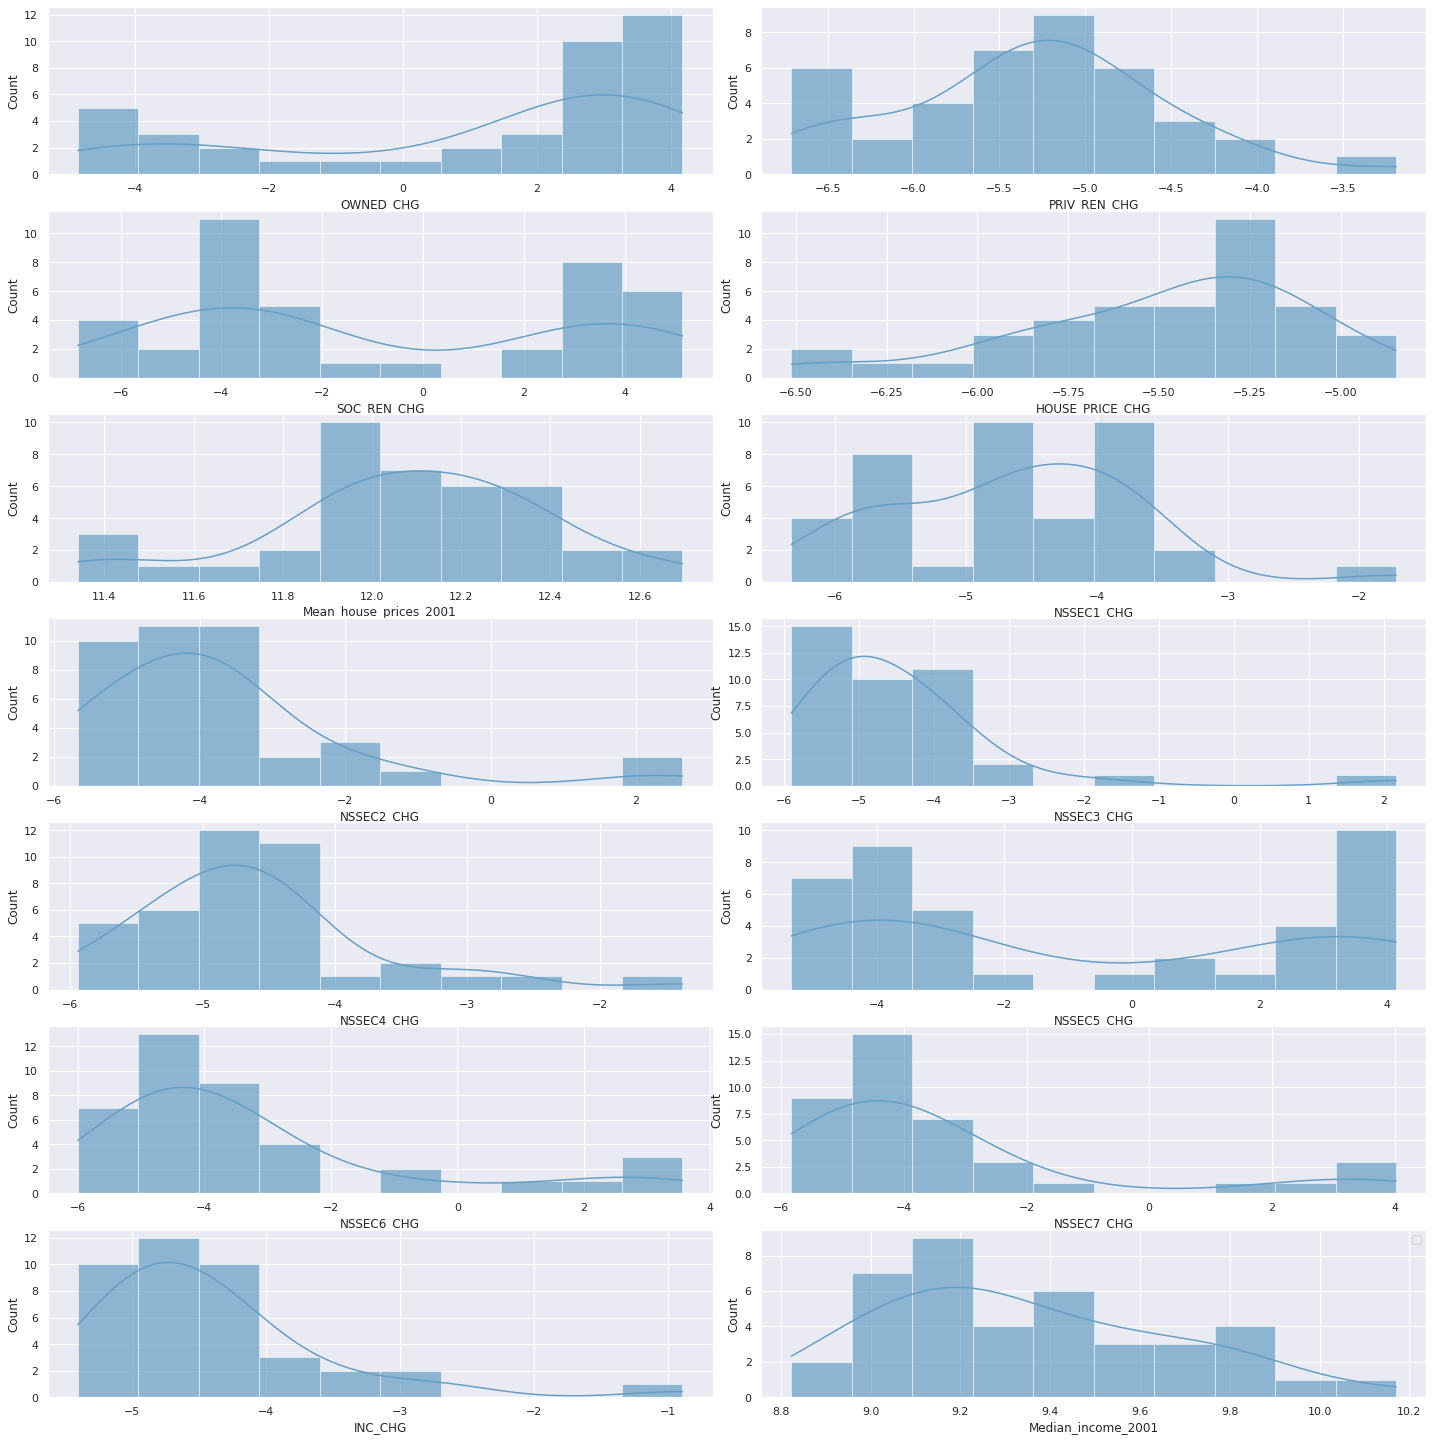

In [50]:
fig, axs = plt.subplots(nrows=7, ncols=2, figsize=(20,20))
fig.tight_layout()

sns.set(style="whitegrid")
sns.set(font_scale = 1)

sns.histplot(ax=axs[0,0],data=cluster_2_invSine, x="OWNED_CHG", kde=True, legend = True, color="#669EC4", linewidth=0.5, alpha=0.7, bins=10)
sns.histplot(ax=axs[0,1],data=cluster_2_invSine, x="PRIV_REN_CHG", kde=True, legend = True, color="#669EC4", linewidth=0.5, alpha=0.7, bins=10)

sns.histplot(ax=axs[1,0],data=cluster_2_invSine, x="SOC_REN_CHG", kde=True, legend = True, color="#669EC4", linewidth=0.5, alpha=0.7, bins=10)
sns.histplot(ax=axs[1,1],data=cluster_2_invSine, x="HOUSE_PRICE_CHG", kde=True, legend = True, color="#669EC4", linewidth=0.5, alpha=0.7, bins=10)

sns.histplot(ax=axs[2, 0],data=cluster_2_invSine, x="Mean_house_prices_2001", kde=True, legend = True, color="#669EC4", linewidth=0.5, alpha=0.7, bins=10)
sns.histplot(ax=axs[2,1],data=cluster_2_invSine, x="NSSEC1_CHG", kde=True, legend = True, color="#669EC4", linewidth=0.5, alpha=0.7, bins=10)

sns.histplot(ax=axs[3,0],data=cluster_2_invSine, x="NSSEC2_CHG", kde=True, legend = True, color="#669EC4", linewidth=0.5, alpha=0.7, bins=10)
sns.histplot(ax=axs[3,1],data=cluster_2_invSine, x="NSSEC3_CHG", kde=True, legend = True, color="#669EC4", linewidth=0.5, alpha=0.7, bins=10)

sns.histplot(ax=axs[4,0],data=cluster_2_invSine, x="NSSEC4_CHG", kde=True, legend = True, color="#669EC4", linewidth=0.5, alpha=0.7, bins=10)
sns.histplot(ax=axs[4,1],data=cluster_2_invSine, x="NSSEC5_CHG", kde=True, legend = True, color="#669EC4", linewidth=0.5, alpha=0.7, bins=10)

sns.histplot(ax=axs[5,0],data=cluster_2_invSine, x="NSSEC6_CHG", kde=True, legend = True, color="#669EC4", linewidth=0.5, alpha=0.7, bins=10)
sns.histplot(ax=axs[5,1],data=cluster_2_invSine, x="NSSEC7_CHG", kde=True, legend = True, color="#669EC4", linewidth=0.5, alpha=0.7, bins=10)

sns.histplot(ax=axs[6,0],data=cluster_2_invSine, x="INC_CHG", kde=True, legend = True, color="#669EC4", linewidth=0.5, alpha=0.7, bins=10)
sns.histplot(ax=axs[6,1],data=cluster_2_invSine, x="Median_income_2001", kde=True, legend = True, color="#669EC4", linewidth=0.5, alpha=0.7, bins=10)

plt.legend() 

plt.savefig(os.path.join("Figures", 'hist_cluster_2_invSine.png'), transparent=True, dpi=300)

plt.show()

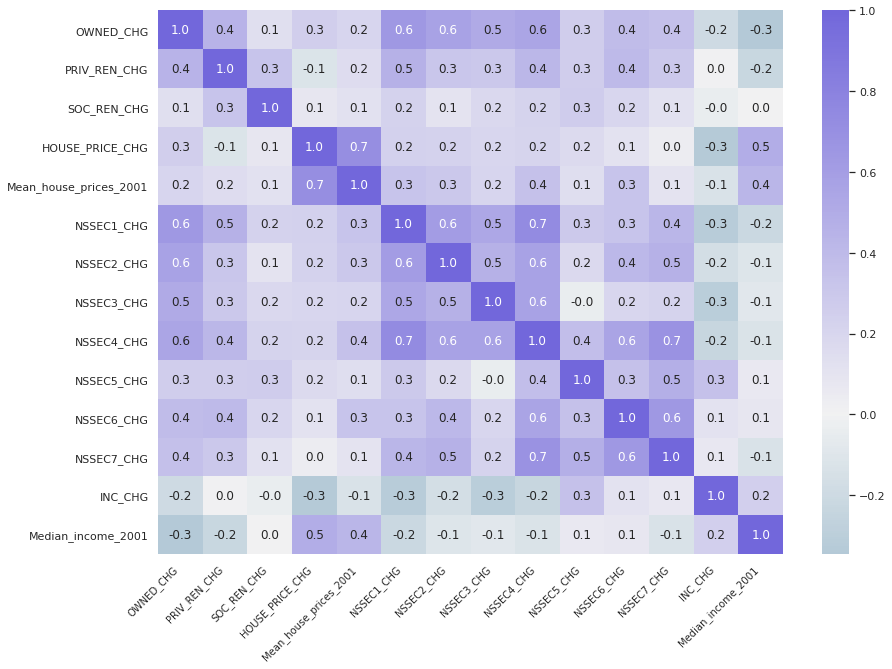

In [51]:
# check for multi-collinearity between variables

fig, ax = plt.subplots()
fig.set_size_inches(14, 10)
cmap = sns.diverging_palette(235.5, 268.1, as_cmap=True)

ax=sns.heatmap(cluster_2_invSine.corr(), cmap=cmap, center=0, annot=True, fmt=".1f")
plt.xticks(rotation=45,ha='right',fontsize=10)

plt.savefig(os.path.join("Figures", 'heat_cluster_2_invSine.png'), transparent=False, dpi=300)

# 4.3 Rescale

In [52]:
# applying z-score standardisation on all 4 datasets

from scipy.stats import zscore

cluster_2_noTrans_zscore = cluster_2_noTrans.apply(zscore)
cluster_2_cubeRoot_zscore = cluster_2_cubeRoot.apply(zscore)
cluster_2_yeoJohnson_zscore = cluster_2_yeoJohnson.apply(zscore)
cluster_2_invSine_zscore = cluster_2_invSine.apply(zscore)

In [53]:
# applying RobustScaler (inter-quartile range standardisation) on all 4 datasets

from sklearn.preprocessing import RobustScaler

transformer1 = RobustScaler().fit(cluster_2_noTrans)
cluster_2_noTrans_robust = transformer1.transform(cluster_2_noTrans)
cluster_2_noTrans_robust = pd.DataFrame(cluster_2_noTrans_robust, index = cluster_2_noTrans.index, columns = cluster_2_noTrans.columns)


transformer2 = RobustScaler().fit(cluster_2_cubeRoot)
cluster_2_cubeRoot_robust = transformer2.transform(cluster_2_cubeRoot)
cluster_2_cubeRoot_robust = pd.DataFrame(cluster_2_cubeRoot_robust, index = cluster_2_cubeRoot.index, columns = cluster_2_cubeRoot.columns)


transformer3 = RobustScaler().fit(cluster_2_yeoJohnson)
cluster_2_yeoJohnson_robust = transformer3.transform(cluster_2_yeoJohnson)
cluster_2_yeoJohnson_robust = pd.DataFrame(cluster_2_yeoJohnson_robust, index = cluster_2_yeoJohnson.index, columns = cluster_2_yeoJohnson.columns)


transformer4 = RobustScaler().fit(cluster_2_invSine)
cluster_2_invSine_robust = transformer4.transform(cluster_2_invSine)
cluster_2_invSine_robust = pd.DataFrame(cluster_2_invSine_robust, index = cluster_2_invSine.index, columns = cluster_2_invSine.columns)

In [54]:
# applying RobustScaler (inter-decile range standardisation) on all 4 datasets

transformer5 = RobustScaler(quantile_range=(10.0, 90.0)).fit(cluster_2_noTrans)
cluster_2_noTrans_decile = transformer5.transform(cluster_2_noTrans)
cluster_2_noTrans_decile = pd.DataFrame(cluster_2_noTrans_decile, index = cluster_2_noTrans.index, columns = cluster_2_noTrans.columns)


transformer6 = RobustScaler(quantile_range=(10.0, 90.0)).fit(cluster_2_cubeRoot)
cluster_2_cubeRoot_decile = transformer6.transform(cluster_2_cubeRoot)
cluster_2_cubeRoot_decile = pd.DataFrame(cluster_2_cubeRoot_decile, index = cluster_2_cubeRoot.index, columns = cluster_2_cubeRoot.columns)


transformer7 = RobustScaler(quantile_range=(10.0, 90.0)).fit(cluster_2_yeoJohnson)
cluster_2_yeoJohnson_decile = transformer7.transform(cluster_2_yeoJohnson)
cluster_2_yeoJohnson_decile = pd.DataFrame(cluster_2_yeoJohnson_decile, index = cluster_2_yeoJohnson.index, columns = cluster_2_yeoJohnson.columns)


transformer8 = RobustScaler(quantile_range=(10.0, 90.0)).fit(cluster_2_invSine)
cluster_2_invSine_decile = transformer8.transform(cluster_2_invSine)
cluster_2_invSine_decile = pd.DataFrame(cluster_2_invSine_decile, index = cluster_2_invSine.index, columns = cluster_2_invSine.columns)

In [55]:
cluster_2_yeoJohnson_decile

,OWNED_CHG,PRIV_REN_CHG,SOC_REN_CHG,HOUSE_PRICE_CHG,Mean_house_prices_2001,NSSEC1_CHG,NSSEC2_CHG,NSSEC3_CHG,NSSEC4_CHG,NSSEC5_CHG,NSSEC6_CHG,NSSEC7_CHG,INC_CHG,Median_income_2001
LSOA11CD,,,,,,,,,,,,,,
E01024044,0.236221,0.101671,-0.557645,0.103873,0.237600,-0.082264,0.035696,0.584719,0.194359,-0.315486,0.192429,0.050268,-0.337587,-0.002351
E01024046,-0.157992,-0.263023,-0.094149,0.528360,0.843619,0.281957,-0.161211,-0.208046,0.055121,-0.268766,-0.113815,-0.060191,-0.337586,-0.015980
E01024048,0.568812,-0.099953,0.040736,0.022055,0.125809,-0.055830,0.314297,0.470360,-0.114051,-0.473737,-0.370287,-0.180207,-0.337586,-0.007077
E01024052,-1.385271,-0.749579,0.121114,0.926067,0.384532,-0.771756,-0.794875,-0.354601,-0.330514,0.006751,0.169748,0.312876,0.710837,0.007189
E01024069,-0.092314,0.429291,0.443584,-0.456191,-0.158453,-0.017660,-0.012036,0.360794,0.203741,0.624888,0.530782,0.777698,0.824418,0.007186
E01024070,0.173098,0.450476,0.001280,-0.290594,0.525528,0.198933,0.292447,-0.050797,0.229574,0.431601,0.437441,0.436720,0.824418,0.007187
E01024071,-0.247410,0.028385,-0.155102,-0.485028,-0.167676,-0.507572,-0.113758,-0.478419,-0.016612,0.509481,-0.138198,0.201019,0.946481,0.007189
E01024082,-0.105336,0.600104,0.236007,-0.509265,-0.569600,0.260525,0.199368,0.274866,0.354422,0.153738,-0.041413,0.318101,0.241285,-6.442654
E01024093,0.085756,-0.023495,-0.054649,-0.486645,-0.051001,-0.487790,0.012036,0.263569,-0.306618,-0.193283,-0.556106,-0.553423,0.640539,-0.029415


In [56]:
# check dataset permutations for heavily-skewed variables

df_full = [cluster_2_noTrans_zscore, cluster_2_cubeRoot_zscore, cluster_2_yeoJohnson_zscore, cluster_2_invSine_zscore, cluster_2_noTrans_robust, cluster_2_cubeRoot_robust, cluster_2_yeoJohnson_robust, cluster_2_invSine_robust, cluster_2_noTrans_decile, cluster_2_cubeRoot_decile, cluster_2_yeoJohnson_decile, cluster_2_invSine_decile]
df_full_name = ["cluster_2_noTrans_zscore", "cluster_2_cubeRoot_zscore", "cluster_2_yeoJohnson_zscore", "cluster_2_invSine_zscore", "cluster_2_noTrans_robust", "cluster_2_cubeRoot_robust", "cluster_2_yeoJohnson_robust", "cluster_2_invSine_robust", "cluster_2_noTrans_decile", "cluster_2_cubeRoot_decile", "cluster_2_yeoJohnson_decile", "cluster_2_invSine_decile"]

for method in range(len(df_full)):
    counter = 0
    for col in range(0,8):
        if df_full[method][df_full[method].columns[col]].skew() > 1:
            counter += 1
        elif df_full[method][df_full[method].columns[col]].skew() <- 1:
            counter += 1
    print(str(df_full_name[method]) + " has " + str(counter) + " variables with skew >1 or <-1 \n")

cluster_2_noTrans_zscore has 6 variables with skew >1 or <-1 

cluster_2_cubeRoot_zscore has 3 variables with skew >1 or <-1 

cluster_2_yeoJohnson_zscore has 2 variables with skew >1 or <-1 

cluster_2_invSine_zscore has 2 variables with skew >1 or <-1 

cluster_2_noTrans_robust has 6 variables with skew >1 or <-1 

cluster_2_cubeRoot_robust has 3 variables with skew >1 or <-1 

cluster_2_yeoJohnson_robust has 2 variables with skew >1 or <-1 

cluster_2_invSine_robust has 2 variables with skew >1 or <-1 

cluster_2_noTrans_decile has 6 variables with skew >1 or <-1 

cluster_2_cubeRoot_decile has 3 variables with skew >1 or <-1 

cluster_2_yeoJohnson_decile has 2 variables with skew >1 or <-1 

cluster_2_invSine_decile has 2 variables with skew >1 or <-1 



For n_clusters = 2 The average silhouette_score is : 0.5371567092432581
For n_clusters = 3 The average silhouette_score is : 0.520117155213427
For n_clusters = 4 The average silhouette_score is : 0.5558093503366098
For n_clusters = 5 The average silhouette_score is : 0.5759780878400317
For n_clusters = 6 The average silhouette_score is : 0.60791263152208
For n_clusters = 7 The average silhouette_score is : 0.5874459071748133
For n_clusters = 8 The average silhouette_score is : 0.5863534491338711
For n_clusters = 9 The average silhouette_score is : 0.5429142977258945
For n_clusters = 10 The average silhouette_score is : 0.5018409666029948


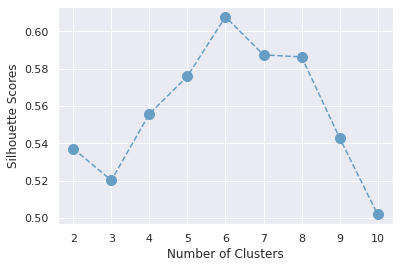

In [57]:
# check and plot silhouette scores to determine the optimal number of clusters
import sklearn.utils._cython_blas

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

silhouette_scores = []
range_n_clusters = [2, 3, 4, 5, 6, 7, 8, 9, 10]
Sum_of_squared_distances = []

for n_clusters in range_n_clusters:
    clusterer = KMeans(n_clusters=n_clusters, random_state=0)
    cluster_labels = clusterer.fit_predict(cluster_2)
    Sum_of_squared_distances.append(clusterer.inertia_)
    
    silhouette_avg = silhouette_score(cluster_2, cluster_labels)
    silhouette_scores.append(silhouette_avg)
    print("For n_clusters =", n_clusters, "The average silhouette_score is :", silhouette_avg)

clusters = pd.DataFrame(silhouette_scores, index=None).reset_index().rename(columns={"index":"Cluster",0:"silhouette_score"})

plt.plot(range_n_clusters, silhouette_scores, 'o--', color="#669EC4", ms=10)
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Scores')
plt.savefig(os.path.join("Figures", 'line_cluster2_sil.png'), transparent=True, dpi=300)
plt.show()

# 4.3 Cluster

In [58]:
# k-means clustering for yeo-johnson dataset permutations

from sklearn.cluster import KMeans

cluster_2_yeoJohnson_zscore_kmeans = KMeans(n_clusters=3, init="k-means++", random_state=0, n_init=6000, max_iter=80000).fit(cluster_2_yeoJohnson_zscore)
cluster_2_yeoJohnson_robust_kmeans = KMeans(n_clusters=3, init="k-means++", random_state=0, n_init=6000, max_iter=80000).fit(cluster_2_yeoJohnson_robust)
cluster_2_yeoJohnson_decile_kmeans = KMeans(n_clusters=3, init="k-means++", random_state=0, n_init=6000, max_iter=80000).fit(cluster_2_yeoJohnson_decile)

cluster_2_yeoJohnson_zscore_labels = cluster_2_yeoJohnson_zscore_kmeans.labels_
cluster_2_yeoJohnson_robust_labels = cluster_2_yeoJohnson_robust_kmeans.labels_
cluster_2_yeoJohnson_decile_labels = cluster_2_yeoJohnson_decile_kmeans.labels_

In [59]:
cluster_2_yJ_zscore_original = cluster_2[:]
cluster_2_yJ_zscore_original["cluster_2_yeoJohnson_zscore_labels"]=cluster_2_yeoJohnson_zscore_labels

/opt/conda/envs/sds2021/lib/python3.9/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


In [60]:
cluster_2_yJ_robust_original = cluster_2[:]
cluster_2_yJ_robust_original["cluster_2_yeoJohnson_robust_labels"]=cluster_2_yeoJohnson_robust_labels

In [61]:
cluster_2_yJ_decile_original = cluster_2[:]
cluster_2_yJ_decile_original["cluster_2_yeoJohnson_decile_labels"]=cluster_2_yeoJohnson_decile_labels

In [62]:
# creating empty array to hold the performance measure for each cluster derived from individual dataset permutation

permutation = ["yeoJohnson_zscore", "yeoJohnson_robust","yeoJohnson_decile"]
calinski_harabasz_scores = []

In [63]:
# measuring the performance for yeo-johnson dataset permutations

from sklearn import metrics
from sklearn.metrics import pairwise_distances

print(metrics.calinski_harabasz_score(cluster_2_yJ_zscore_original, cluster_2_yeoJohnson_zscore_labels))
calinski_harabasz_scores.append(metrics.calinski_harabasz_score(cluster_2_yJ_zscore_original, cluster_2_yeoJohnson_zscore_labels))

print(metrics.calinski_harabasz_score(cluster_2_yJ_robust_original, cluster_2_yeoJohnson_robust_labels))
calinski_harabasz_scores.append(metrics.calinski_harabasz_score(cluster_2_yJ_robust_original, cluster_2_yeoJohnson_robust_labels))

print(metrics.calinski_harabasz_score(cluster_2_yJ_decile_original, cluster_2_yeoJohnson_decile_labels))
calinski_harabasz_scores.append(metrics.calinski_harabasz_score(cluster_2_yJ_decile_original, cluster_2_yeoJohnson_decile_labels))

9.501777065680843
4.269546992423806
6.438613818651895


/tmp/ipykernel_665/423199229.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(permutation, fontsize=14)
/tmp/ipykernel_665/423199229.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(range(0,140,20), fontsize=14)


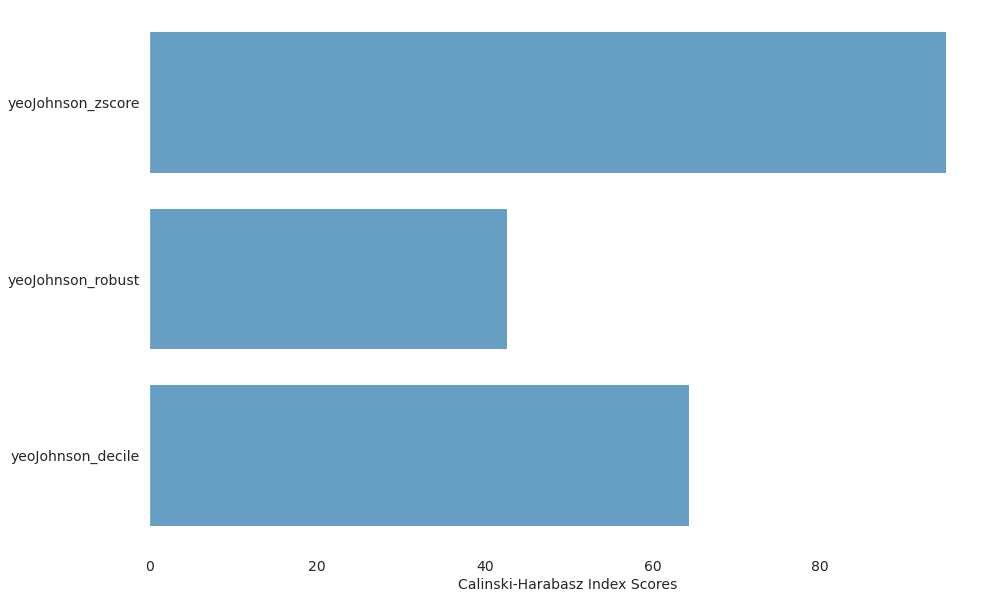

In [64]:
plt.rcParams['axes.facecolor'] = 'white'

fig, ax = plt.subplots(figsize=(15, 10))

bar = plt.barh(permutation, calinski_harabasz_scores, color = ["#669EC4"])

for i in range(len(permutation)):
    plt.text(x = calinski_harabasz_scores[i], y = i, s = calinski_harabasz_scores[i].round(2), size = 20, color="white")
    
ax.set_yticklabels(permutation, fontsize=14)
ax.set_xticklabels(range(0,140,20), fontsize=14)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Calinski-Harabasz Index Scores',fontsize=14)

plt.savefig(os.path.join("Figures", 'bar_gent_cluster2_perf.png'), transparent=True, dpi=300)

plt.show()

/tmp/ipykernel_665/1952879271.py:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(permutation, fontsize=14)


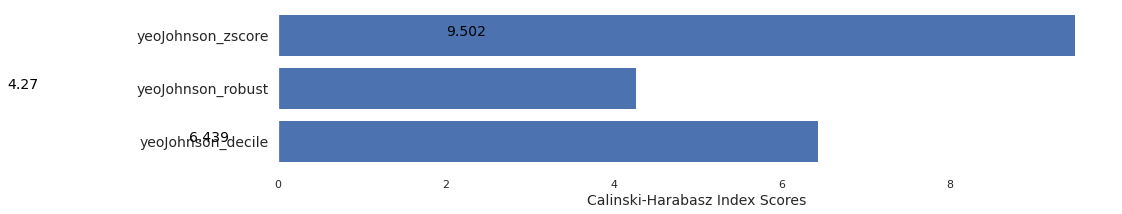

In [65]:
# visualise all performance scores using a barplot

fig, ax = plt.subplots(figsize=(15, 3))

ax.barh(permutation, calinski_harabasz_scores)
#ax.set_yticks(y_pos)
ax.set_yticklabels(permutation, fontsize=14)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Calinski-Harabasz Index Scores', fontsize=14)
#ax.set_title('Quality of Clusters from Different Dataset Permutations')

for i in range(len(permutation)):
    plt.text(x = calinski_harabasz_scores[i]-7.5, y = i, s = calinski_harabasz_scores[i].round(3), size = 14, color='black')

plt.show()

In [66]:
# extracting cluster details of the best-performing dataset

cluster_2_yJ_zscore_original.groupby("cluster_2_yeoJohnson_zscore_labels").size()

cluster_2_yeoJohnson_zscore_labels
0     4
1    27
2     9
dtype: int64

In [67]:
# appending cluster labels to main dataset

cluster_2_yeoJohnson_zscore["cluster_2_yeoJohnson_zscore_labels"]=cluster_2_yeoJohnson_zscore_labels

In [68]:
# creating a new dataset for plotting purposes

radar_2 = cluster_2_yeoJohnson_zscore.groupby("cluster_2_yeoJohnson_zscore_labels").mean()
radar_2 = radar_2.reset_index()

In [137]:
radar_2

,cluster_2_yeoJohnson_zscore_labels,OWNED_CHG,PRIV_REN_CHG,SOC_REN_CHG,HOUSE_PRICE_CHG,Mean_house_prices_2001,NSSEC1_CHG,NSSEC2_CHG,NSSEC3_CHG,NSSEC4_CHG,NSSEC5_CHG,NSSEC6_CHG,NSSEC7_CHG,INC_CHG,Median_income_2001
0,0,-1.188776,-1.195706,-2.028766,-1.428067,-2.108413,-1.385774,-1.658957,-1.567352,-1.752708,-1.999481,-1.835619,-1.407990,0.710948,-0.996080
1,1,0.475865,0.472867,0.344515,0.087008,0.276797,0.614674,0.583737,0.513897,0.537272,0.308122,0.488674,0.365813,-0.235953,0.028960
2,2,-0.899250,-0.887175,-0.131871,0.373672,0.106681,-1.228122,-1.013897,-0.845089,-0.832835,-0.035706,-0.650192,-0.471664,0.391881,0.355822


In [69]:
# appending dataset average values to main dataset

radar_avg = cluster_2_yeoJohnson_zscore.drop(columns = ["cluster_2_yeoJohnson_zscore_labels"]).mean().reset_index()

In [117]:
radar_2.to_csv("gentnuance.csv")

In [71]:
# rename columns for legibility

radar_avg = radar_avg.rename(columns={"index":"var", 0: "value"})

In [132]:
len(cluster_2_yeoJohnson_zscore)

40

In [136]:
x = cluster_2_yeoJohnson_zscore[["NSSEC6_CHG"]].sum(axis=1)
z = sum(x)/40
z

-1.6653345369377347e-17

In [118]:
radar_avg.to_csv("radar_avg.csv")

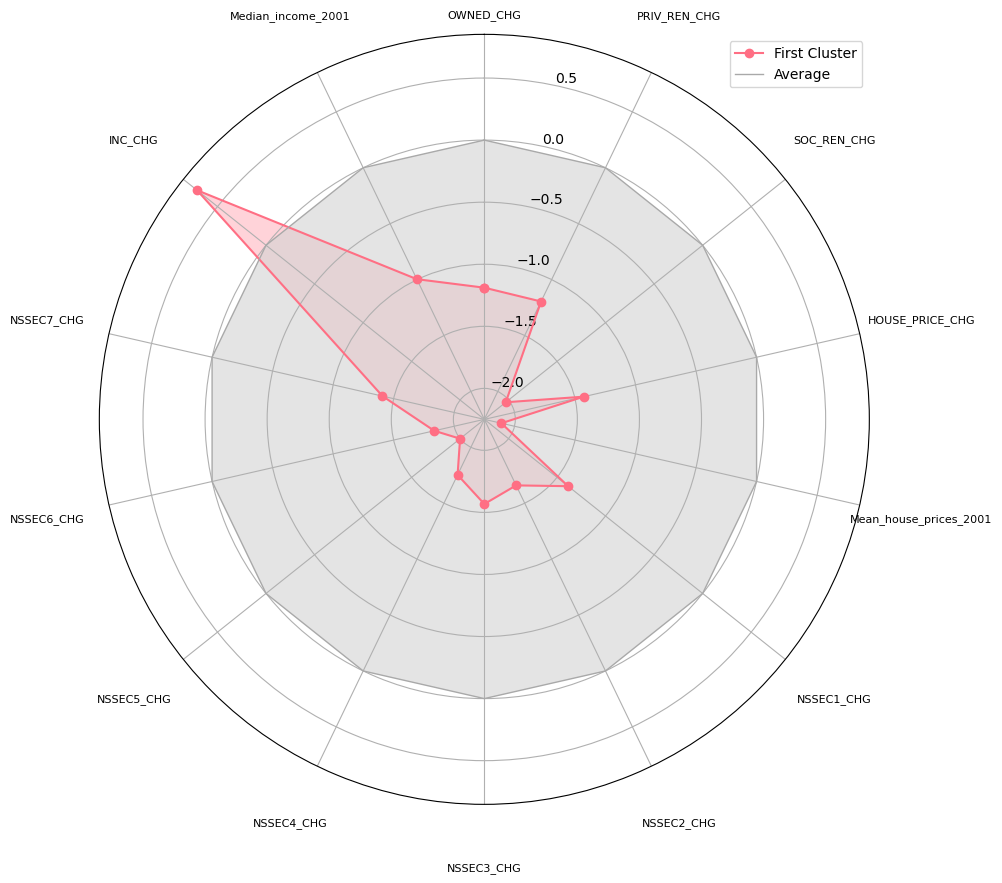

In [72]:
# Reference for code: https://python-graph-gallery.com/391-radar-chart-with-several-individuals/
# plot the 1st cluster
plt.style.use('default')

from math import pi

fig1, ax = plt.subplots()
fig1.set_size_inches(14, 10)

# number of variabl
categories=list(radar_2)[0:]
N = len(categories)
 
# plotting for the 1st variable
values=radar_2.iloc[0,1:].values.flatten().tolist()
values += values[:1]
values

# ------- PART 1: Create background
 
# number of variables
categories=list(radar_2)[1:]
N = len(categories)
 
# angles for plotting
angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]
 
# Initialise the spider plot
ax = plt.subplot(111, polar=True)
 
# If you want the first axis to be on top:
ax.set_theta_offset(pi / 2)
ax.set_theta_direction(-1)
 
# Draw one axe per variable + add labels labels yet
ax.set_rlabel_position(0)
plt.rcParams['xtick.major.pad']='35'
plt.xticks(angles[:-1], categories, size = 8, rotation=90)
 
# Draw ylabels
ax.set_rlabel_position(12)
#plt.ylim(-2,1)
 
# ------- PART 2: Add plots
 
# Plot each individual = each line of the data
 
# Ind1
values=radar_2.iloc[0,1:].values.flatten().tolist()
values += values[:1]
ax.plot(angles, values, linewidth=1.5, color = "#ff6f84", linestyle='solid', marker="o", label="First Cluster")
ax.fill(angles, values, '#ff6f84', alpha=0.3)
 
# Ind2
values=radar_avg.iloc[:,1].values.flatten().tolist()
values += values[:1]
ax.plot(angles, values, linewidth=1, color="darkgrey", linestyle='solid', label="Average")
ax.fill(angles, values, 'lightgrey', alpha=0.6)
 
# Add legend

plt.savefig(os.path.join("Figures", 'spider_gent2_cluster1.png'), transparent=True, dpi=300)

plt.legend(loc='upper right')

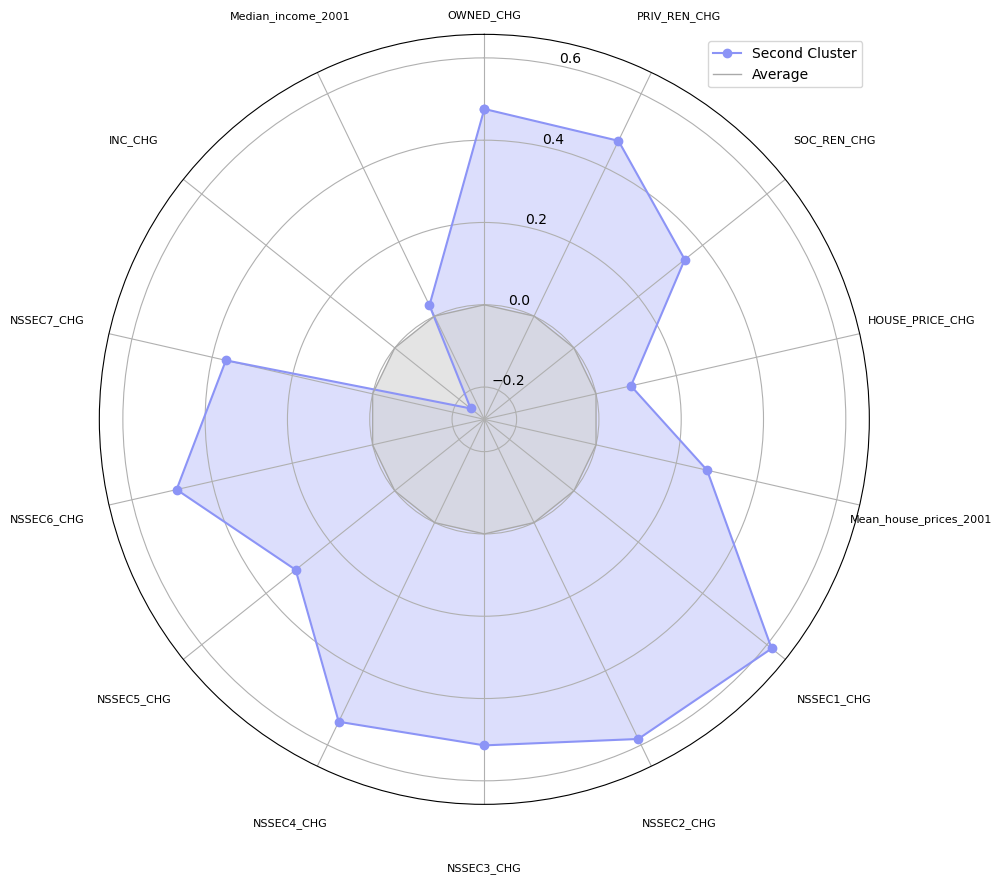

In [73]:
# Reference for code: https://python-graph-gallery.com/391-radar-chart-with-several-individuals/
# plot the 1st cluster
plt.style.use('default')

from math import pi

fig1, ax = plt.subplots()
fig1.set_size_inches(14, 10)

# number of variabl
categories=list(radar_2)[0:]
N = len(categories)
 
# plotting for the 1st variable
values=radar_2.iloc[1,1:].values.flatten().tolist()
values += values[:1]
values

# ------- PART 1: Create background
 
# number of variables
categories=list(radar_2)[1:]
N = len(categories)
 
# angles for plotting
angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]
 
# Initialise the spider plot
ax = plt.subplot(111, polar=True)
 
# If you want the first axis to be on top:
ax.set_theta_offset(pi / 2)
ax.set_theta_direction(-1)
 
# Draw one axe per variable + add labels labels yet
ax.set_rlabel_position(0)
plt.rcParams['xtick.major.pad']='35'
plt.xticks(angles[:-1], categories, size = 8, rotation=90)
 
# Draw ylabels
ax.set_rlabel_position(12)
#plt.ylim(-2,1)
 
# ------- PART 2: Add plots
 
# Plot each individual = each line of the data
 
# Ind1
values=radar_2.iloc[1,1:].values.flatten().tolist()
values += values[:1]
ax.plot(angles, values, linewidth=1.5, color = "#8c94f6", linestyle='solid', marker="o", label="Second Cluster")
ax.fill(angles, values, '#8c94f6', alpha=0.3)
 
# Ind2
values=radar_avg.iloc[:,1].values.flatten().tolist()
values += values[:1]
ax.plot(angles, values, linewidth=1, color="darkgrey", linestyle='solid', label="Average")
ax.fill(angles, values, 'lightgrey', alpha=0.6)
 
# Add legend

plt.savefig(os.path.join("Figures", 'spider_gent2_cluster2.png'), transparent=True, dpi=300)

plt.legend(loc='upper right')

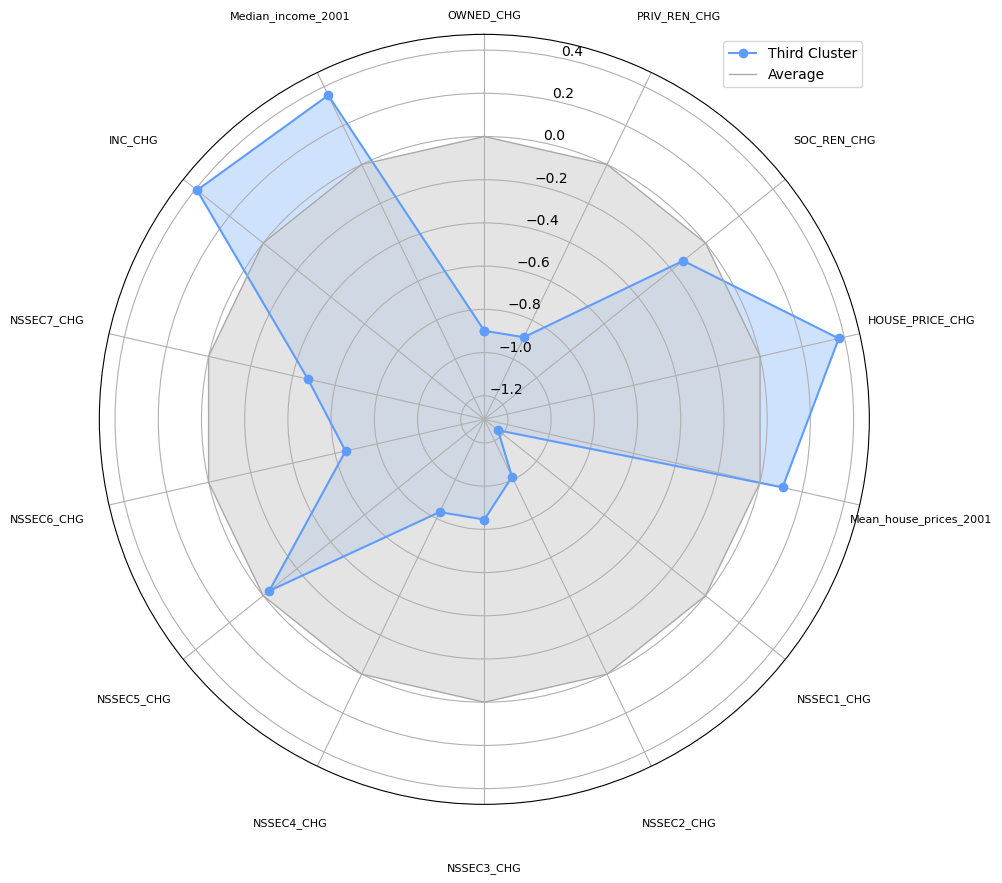

In [74]:
# Reference for code: https://python-graph-gallery.com/391-radar-chart-with-several-individuals/
# plot the 1st cluster
plt.style.use('default')

from math import pi

fig1, ax = plt.subplots()
fig1.set_size_inches(14, 10)

# number of variabl
categories=list(radar_2)[0:]
N = len(categories)
 
# plotting for the 1st variable
values=radar_2.iloc[2,1:].values.flatten().tolist()
values += values[:1]
values

# ------- PART 1: Create background
 
# number of variables
categories=list(radar_2)[1:]
N = len(categories)
 
# angles for plotting
angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]
 
# Initialise the spider plot
ax = plt.subplot(111, polar=True)
 
# If you want the first axis to be on top:
ax.set_theta_offset(pi / 2)
ax.set_theta_direction(-1)
 
# Draw one axe per variable + add labels labels yet
ax.set_rlabel_position(0)
plt.rcParams['xtick.major.pad']='35'
plt.xticks(angles[:-1], categories, size = 8, rotation=90)
 
# Draw ylabels
ax.set_rlabel_position(12)
#plt.ylim(-2,1)
 
# ------- PART 2: Add plots
 
# Plot each individual = each line of the data
 
# Ind1
values=radar_2.iloc[2,1:].values.flatten().tolist()
values += values[:1]
ax.plot(angles, values, linewidth=1.5, color = "#5f9cfb", linestyle='solid', marker="o", label="Third Cluster")
ax.fill(angles, values, '#5f9cfb', alpha=0.3)
 
# Ind2
values=radar_avg.iloc[:,1].values.flatten().tolist()
values += values[:1]
ax.plot(angles, values, linewidth=1, color="darkgrey", linestyle='solid', label="Average")
ax.fill(angles, values, 'lightgrey', alpha=0.6)
 
# Add legend

plt.savefig(os.path.join("Figures", 'spider_gent2_cluster3.png'), transparent=True, dpi=300)

plt.legend(loc='upper right')

# 5. Plot

In [75]:
# parse cluster labels to derive their categories 

cluster_2_yeoJohnson_zscore = cluster_2_yeoJohnson_zscore.reset_index()
cluster_2_yeoJohnson_zscore["cluster_2_yeoJohnson_zscore_cat"]=""

for i in range(len(cluster_2_yeoJohnson_zscore)):
    if cluster_2_yeoJohnson_zscore.loc[i, "cluster_2_yeoJohnson_zscore_labels"]==0:
        cluster_2_yeoJohnson_zscore.loc[i, "cluster_2_yeoJohnson_zscore_cat"]="cluster4"
    elif cluster_2_yeoJohnson_zscore.loc[i, "cluster_2_yeoJohnson_zscore_labels"]==1:
        cluster_2_yeoJohnson_zscore.loc[i, "cluster_2_yeoJohnson_zscore_cat"]="cluster5"
    elif cluster_2_yeoJohnson_zscore.loc[i, "cluster_2_yeoJohnson_zscore_labels"]==2:
        cluster_2_yeoJohnson_zscore.loc[i, "cluster_2_yeoJohnson_zscore_cat"]="cluster6"

In [94]:
count

,cluster_2_yeoJohnson_zscore_labels,count
0,0,4
2,2,9
1,1,27


/tmp/ipykernel_665/3944959164.py:25: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(index, size=20)


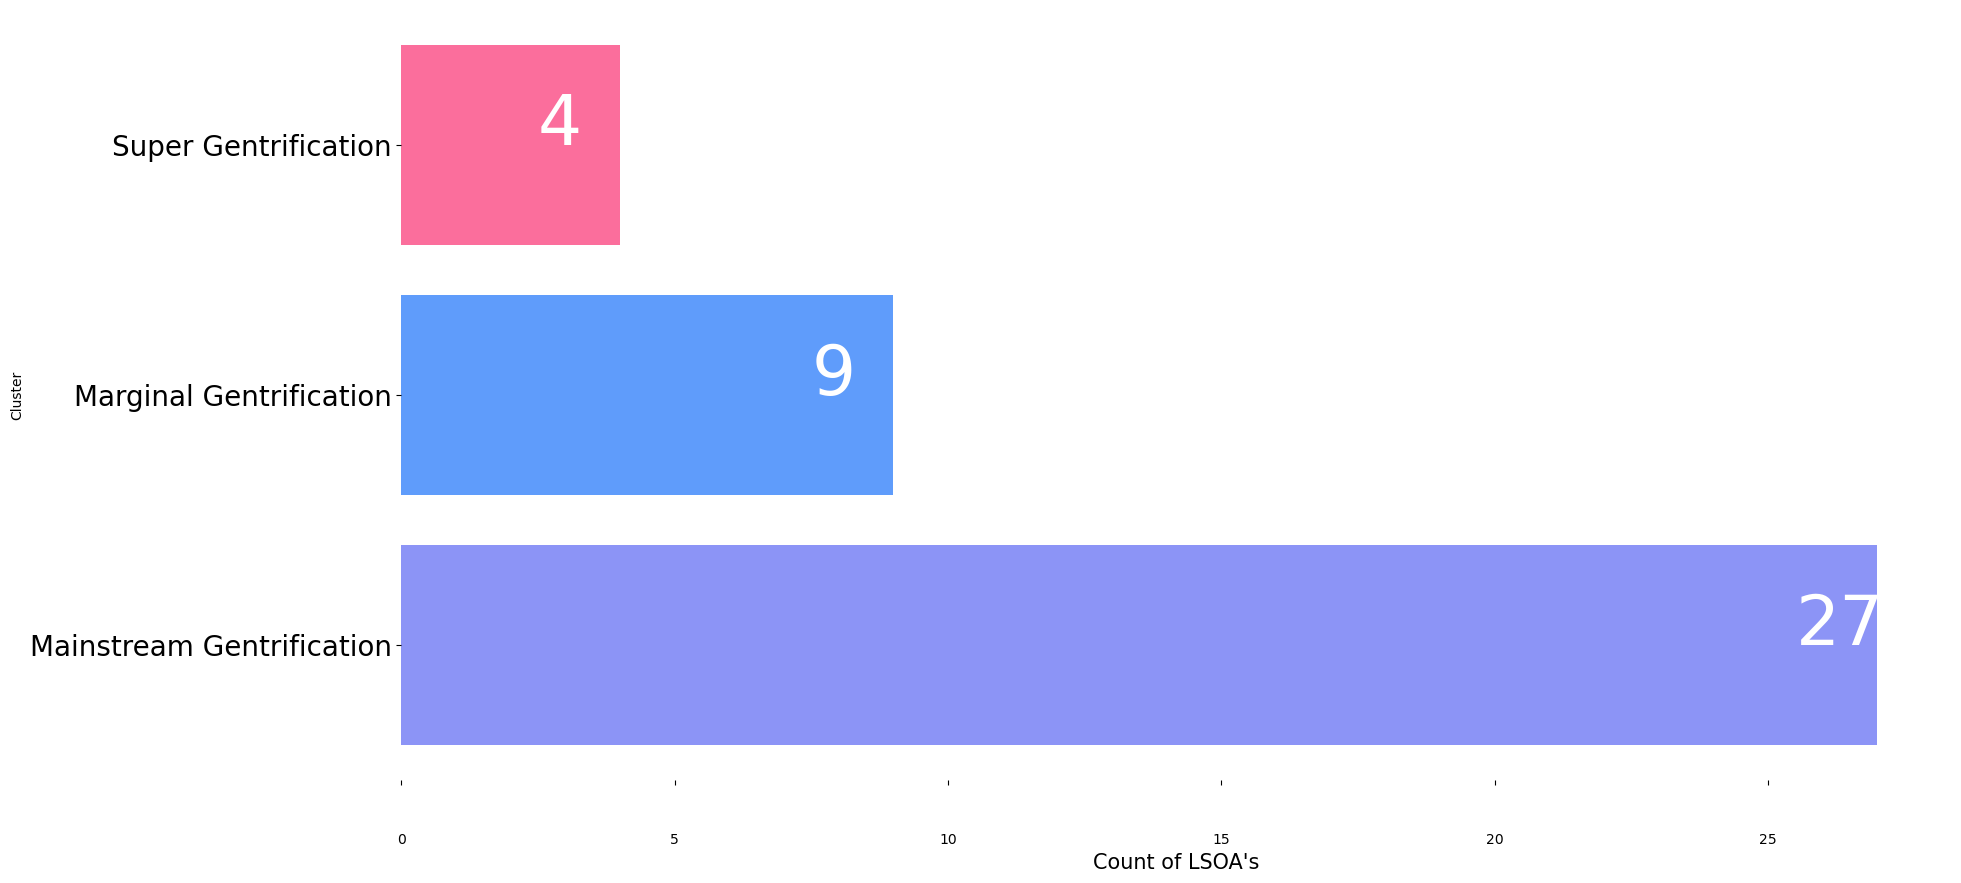

In [138]:
# Plot bar graph of counts

plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['axes.spines.left'] = False
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.bottom'] = False

# check dataframe

count = pd.DataFrame(cluster_2_yeoJohnson_zscore.groupby(cluster_2_yeoJohnson_zscore["cluster_2_yeoJohnson_zscore_cat"]).size()).reset_index()
count = count.rename(columns={0:"count"}).sort_values(by="count", ascending=False)
count

fig, ax = plt.subplots(figsize=(20, 10))

index = ["Mainstream Gentrification", "Marginal Gentrification",  "Super Gentrification"]
bar = plt.barh(count['cluster_2_yeoJohnson_zscore_cat'], count['count'], color = [  "#8c94f6" ,"#5f9cfb","#fb6e9c"])

for i, v in enumerate(count["count"]):
    ax.text(v - 1.5, i , str(v), color='white', size=50)
    
plt.xlabel("Count of LSOA's", size=15)
plt.ylabel('Cluster')
ax.set_yticklabels(index, size=20)
plt.savefig(os.path.join("Figures", 'bar_gent_cats_cluster2_count.png'), transparent=True, dpi=300)

plt.show()

In [78]:
lsoa_2011 = gpd.read_file(os.path.join(shapefiles, "LSOA_KENT_2011.shp"))
outline = gpd.read_file(os.path.join(shapefiles, "KENT_OUTLINE.shp"))
#level1 = gpd.read_file(os.path.join(clean, "ASC.shp"))
level2 = gpd.read_file(os.path.join(clean, "gencluster1.shp"))

In [79]:
cluster_2_yeoJohnson_zscore_gdf = pd.merge(lsoa_2011, cluster_2_yeoJohnson_zscore, on="LSOA11CD", how="right")

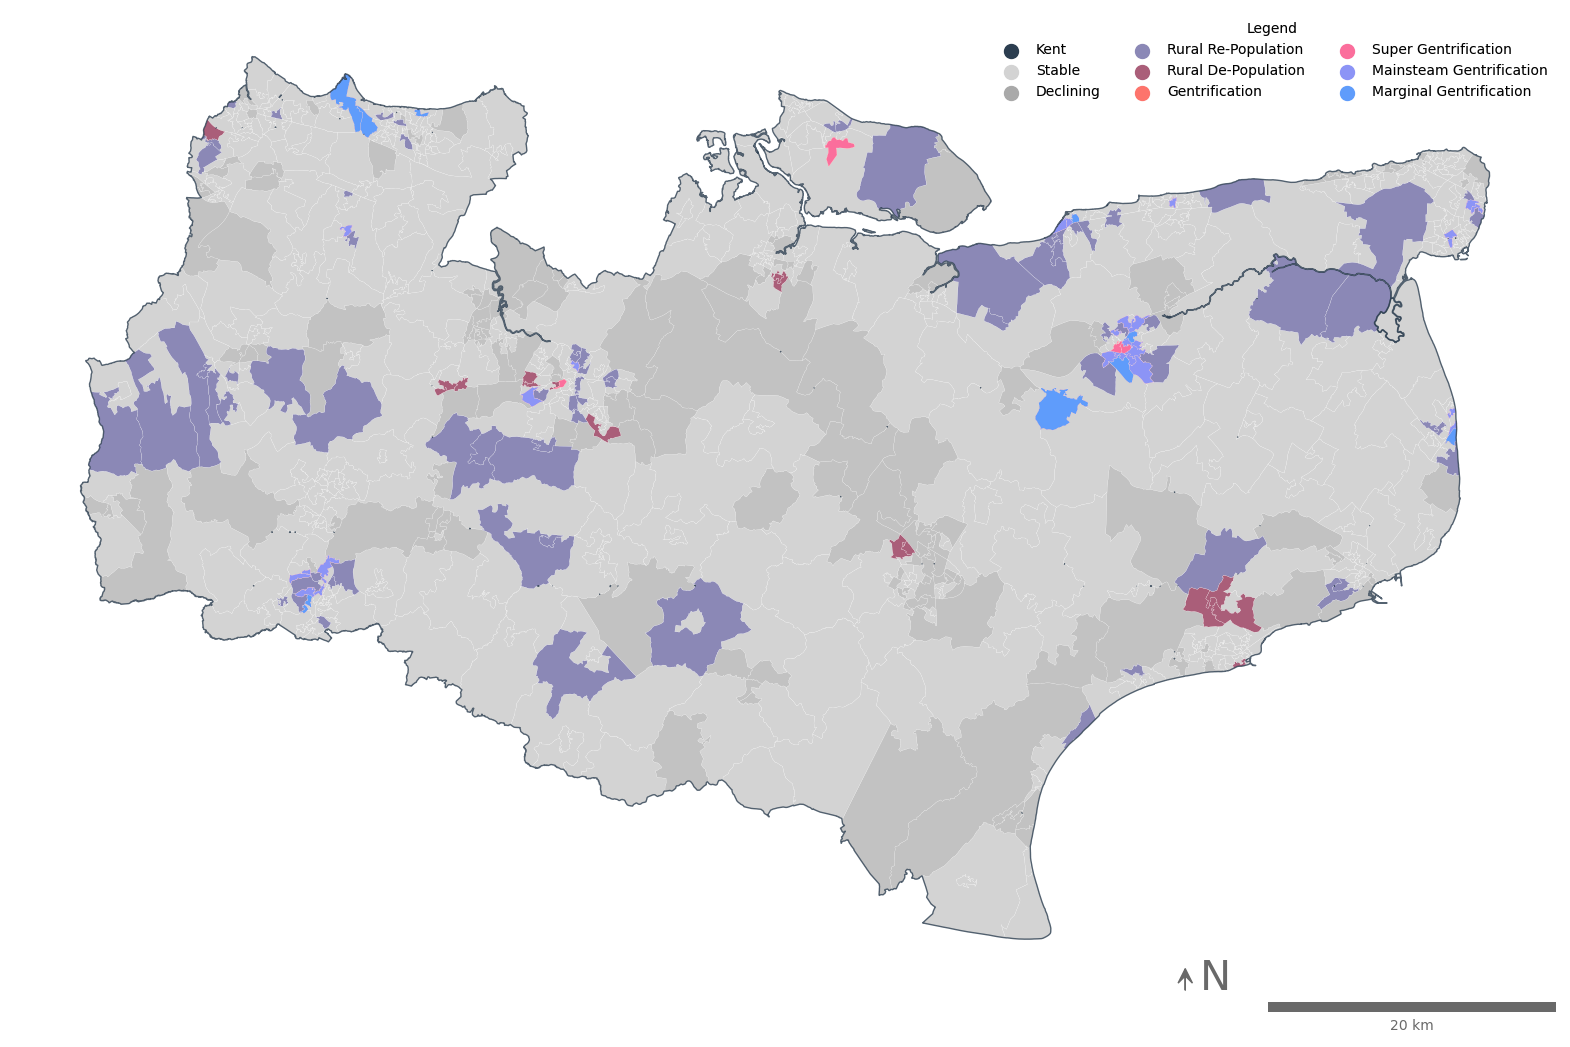

In [139]:
# Filter by status, allowing control over colors of map
stb = level2.loc[level2['Level1Cat'] == "STB"]
dec = level2.loc[level2['Level1Cat'] == "DEC"]

clus1 = level2.loc[level2['Level2Cat'] == "cluster1"]
clus2 = level2.loc[level2['Level2Cat'] == "cluster2"]
clus3 = level2.loc[level2['Level2Cat'] == "cluster3"]

clus4 = cluster_2_yeoJohnson_zscore_gdf.loc[cluster_2_yeoJohnson_zscore_gdf['cluster_2_yeoJohnson_zscore_cat'] == "cluster4"]
clus5 = cluster_2_yeoJohnson_zscore_gdf.loc[cluster_2_yeoJohnson_zscore_gdf['cluster_2_yeoJohnson_zscore_cat'] == "cluster5"]
clus6 = cluster_2_yeoJohnson_zscore_gdf.loc[cluster_2_yeoJohnson_zscore_gdf['cluster_2_yeoJohnson_zscore_cat'] == "cluster6"]

# Set axes
fig, ax = plt.subplots(figsize=(20,20))
ax.set_aspect('equal')
ax.set_facecolor("white")

ax.xaxis.set_visible(False) 
ax.yaxis.set_visible(False) 

# Plot outlines of LSOA'S 
lsoa_2011.plot(ax=ax, edgecolor="white", facecolor="None", alpha=0.8, zorder=10, linewidth=0.1)

# Plot outline of Kent
outline.plot(ax=ax, edgecolor="#2c3e50", facecolor="None", alpha=0.8, zorder=10, linewidth=1)

# Add basemap
#ctx.add_basemap(ax, crs=kent_2011.crs.to_string(), source=ctx.providers.CartoDB.Positron)

# Add scale bar
# Points on the sane lattitude, one longitude apart
points = gpd.GeoSeries([Point(51.5072, 0.1276), Point(52.5072, 0.1276)], crs=4326)
# Calculate difference
distance_meters = points[0].distance(points[1])
# Plot
ax.add_artist(ScaleBar(distance_meters, color="dimgray", location="lower right")) 

# Add north arrow

ax.text(x=620000, y=113000,s='N', fontsize=30, color="dimgray")
ax.arrow(619000, 113000, 0, 1000, length_includes_head=True, head_width=1000, head_length=500, overhang=2, zorder=100, color="dimgray")

stb.plot(ax=ax, facecolor="lightgrey")
dec.plot(ax=ax, facecolor="darkgrey", alpha=0.7)

clus1.plot(ax=ax, facecolor="#8B88B6")
clus2.plot(ax=ax, facecolor="#AA5E79")
clus3.plot(ax=ax, facecolor="#fd746c")

clus4.plot(ax=ax, facecolor="#fb6e9c")
clus5.plot(ax=ax, facecolor="#8c94f6")
clus6.plot(ax=ax, facecolor="#5f9cfb")

# Add legend
l1 = plt.scatter([],[], s=100, marker='o', color='#2c3e50')
l2 = plt.scatter([],[], s=100, marker='o', color='lightgrey')
l3 = plt.scatter([],[], s=100, marker='o', color='darkgrey')
l4 = plt.scatter([],[], s=100, marker='o', color='#8B88B6')
l5 = plt.scatter([],[], s=100, marker='o', color='#AA5E79')
l6 = plt.scatter([],[], s=100, marker='o', color='#fd746c')
l7 = plt.scatter([],[], s=100, marker='o', color='#fb6e9c')
l8 = plt.scatter([],[], s=100, marker='o', color='#8c94f6')
l9 = plt.scatter([],[], s=100, marker='o', color='#5f9cfb')

labels = ["Kent", "Stable","Declining", "Rural Re-Population", "Rural De-Population", "Gentrification", "Super Gentrification", "Mainsteam Gentrification","Marginal Gentrification"]
legend = ax.legend([l1, l2,l3, l4, l5, l6, l7, l8, l9], labels, loc="upper right", title='Legend', facecolor="white", edgecolor="white", ncol=3)    
ax.add_artist(legend)

# Add title
#ax.set_title("Categories of Gentrification for LSOAs in Kent", fontdict={'fontsize': '20','fontweight' : '3'}) 
   
plt.savefig(os.path.join("Figures", 'map_gent_cluster2.png'), transparent=True, dpi=300)

# Show map
plt.show()

# 6. Save

In [81]:
cluster_2_yeoJohnson_zscore_gdf.columns

Index(['LSOA11CD', 'LSOA11NM', 'geometry', 'OWNED_CHG', 'PRIV_REN_CHG',
       'SOC_REN_CHG', 'HOUSE_PRICE_CHG', 'Mean_house_prices_2001',
       'NSSEC1_CHG', 'NSSEC2_CHG', 'NSSEC3_CHG', 'NSSEC4_CHG', 'NSSEC5_CHG',
       'NSSEC6_CHG', 'NSSEC7_CHG', 'INC_CHG', 'Median_income_2001',
       'cluster_2_yeoJohnson_zscore_labels',
       'cluster_2_yeoJohnson_zscore_cat'],
      dtype='object')

In [82]:
cluster_2_yeoJohnson_zscore_gdf_filt = cluster_2_yeoJohnson_zscore_gdf[['LSOA11CD', "cluster_2_yeoJohnson_zscore_cat"]]
cluster_2_yeoJohnson_zscore_gdf_filt = cluster_2_yeoJohnson_zscore_gdf_filt.rename(columns={"cluster_2_yeoJohnson_zscore_cat":"Level3Cat"})


In [83]:
# Merge

level1_level2_level3 = pd.merge(level2, cluster_2_yeoJohnson_zscore_gdf_filt, on="LSOA11CD", how="outer")

In [84]:
level1_level2_level3

,LSOA11CD,LSOA11NM,Score_2001,Score_2011,Rank_2001,Rank_2011,Rank_chg,Z_score,score_chg,Level1Cat,Level2Cat,geometry,Level3Cat
0,E01023972,Ashford 006A,-0.845284,-1.119814,605.0,787.0,-182.0,-1.205786,-0.274530,DEC,DEC,"POLYGON ((602494.344 141509.244, 602498.426 14...",NaN
1,E01023973,Ashford 005A,-0.454671,-1.424423,475.0,865.0,-390.0,-2.583827,-0.969752,DEC,DEC,"POLYGON ((601527.620 141293.178, 601527.125 14...",NaN
2,E01023974,Ashford 007A,-1.704006,-1.550619,865.0,878.0,-13.0,-0.086128,0.153387,STB,STB,"POLYGON ((599609.242 141534.213, 599612.382 14...",NaN
3,E01023975,Ashford 007B,-1.357287,-1.398395,761.0,860.0,-99.0,-0.655894,-0.041109,STB,STB,"POLYGON ((599541.509 141383.033, 599540.728 14...",NaN
4,E01023976,Ashford 008A,-1.305498,-1.207764,745.0,810.0,-65.0,-0.430638,0.097734,STB,STB,"POLYGON ((600185.589 141361.026, 600187.479 14...",NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
897,E01033211,Dover 012F,-0.897899,-1.475208,624.0,871.0,-247.0,-1.636424,-0.577308,DEC,DEC,"POLYGON ((631998.105 141862.895, 632000.000 14...",NaN
898,E01033212,Shepway 014C,-1.888063,-1.189123,886.0,806.0,80.0,0.530016,0.698940,STB,STB,"POLYGON ((622628.323 135841.733, 622619.469 13...",NaN
899,E01033213,Shepway 002E,-1.430556,0.242242,779.0,351.0,428.0,2.835584,1.672798,ASC,cluster2,"POLYGON ((620229.159 139097.666, 620229.125 13...",NaN
900,E01033214,Shepway 002F,-1.569999,0.144610,827.0,378.0,449.0,2.974713,1.714608,ASC,cluster2,"POLYGON ((620865.861 139274.269, 620856.245 13...",NaN


In [85]:
for i in range(len(level1_level2_level3)):
    if level1_level2_level3.loc[i, "Level1Cat"]=="DEC":
        level1_level2_level3.loc[i, "Level3Cat"]="DEC"
    if level1_level2_level3.loc[i, "Level1Cat"]=="STB":
        level1_level2_level3.loc[i, "Level3Cat"]="STB"
    if level1_level2_level3.loc[i, "Level3Cat"]=="NaN":
        level1_level2_level3.loc[i, "Level3Cat"]= level1_level2_level3.loc[i, "Level2Cat"]
        
level1_level2_level3.Level3Cat = level1_level2_level3.Level3Cat.fillna(level1_level2_level3.Level2Cat)


In [86]:
level1_level2_level3.columns

Index(['LSOA11CD', 'LSOA11NM', 'Score_2001', 'Score_2011', 'Rank_2001',
       'Rank_2011', 'Rank_chg', 'Z_score', 'score_chg', 'Level1Cat',
       'Level2Cat', 'geometry', 'Level3Cat'],
      dtype='object')

In [87]:
level1_level2_level3 = level1_level2_level3[['LSOA11CD', 'LSOA11NM', 'Level1Cat',
       'Level2Cat', 'Level3Cat', 'geometry']]

In [88]:
# save

level1_level2_level3.to_csv(os.path.join(clean, "allclusters.csv"))
level1_level2_level3.to_file(os.path.join(clean, "allclusters.shp"))

# 7. Case Studies

In [145]:
cant_info = pd.merge(cluster_2, cant, on="LSOA11CD", how="right")
cant_info.describe()

,OWNED_CHG,PRIV_REN_CHG,SOC_REN_CHG,HOUSE_PRICE_CHG,Mean_house_prices_2001,NSSEC1_CHG,NSSEC2_CHG,NSSEC3_CHG,NSSEC4_CHG,NSSEC5_CHG,NSSEC6_CHG,NSSEC7_CHG,INC_CHG,Median_income_2001
count,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000
mean,2.683988,-123.733328,-19.691104,-144.362460,95717.052632,-75.886506,-37.646180,-59.693712,-64.595616,-16.902843,-41.256025,-34.091032,-57.188525,5529.089791
std,24.819095,107.333669,62.957440,74.955826,28155.395647,65.845806,42.718553,50.210418,48.173733,33.829565,51.235514,45.878955,38.828903,2257.330254
min,-63.798220,-411.111111,-252.189201,-336.734160,43660.804690,-227.500000,-127.717391,-183.797046,-189.456442,-104.031055,-201.033466,-170.679494,-111.086857,3396.939911
25%,-2.397005,-139.530245,-25.225136,-177.521000,81519.000000,-119.732620,-42.888783,-86.970457,-86.363636,-37.943248,-57.317073,-50.000000,-85.733965,4096.437546
50%,9.836066,-88.541667,-8.196721,-114.039125,94869.000000,-50.666667,-26.250000,-53.333333,-53.846154,-13.793103,-19.298246,-22.448980,-58.746895,4936.456421
75%,16.431322,-57.978800,13.167421,-101.847262,110803.000000,-26.296296,-6.538651,-22.579365,-38.642473,9.722222,-11.190932,-9.570802,-24.762860,5930.461899
max,32.513661,-12.121212,44.117647,-63.697387,163250.000000,-2.702703,6.944444,4.301075,-1.851852,30.303030,17.525773,27.956989,-1.012708,13056.073610


/opt/conda/envs/sds2021/lib/python3.9/site-packages/geopandas/plotting.py:678: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(


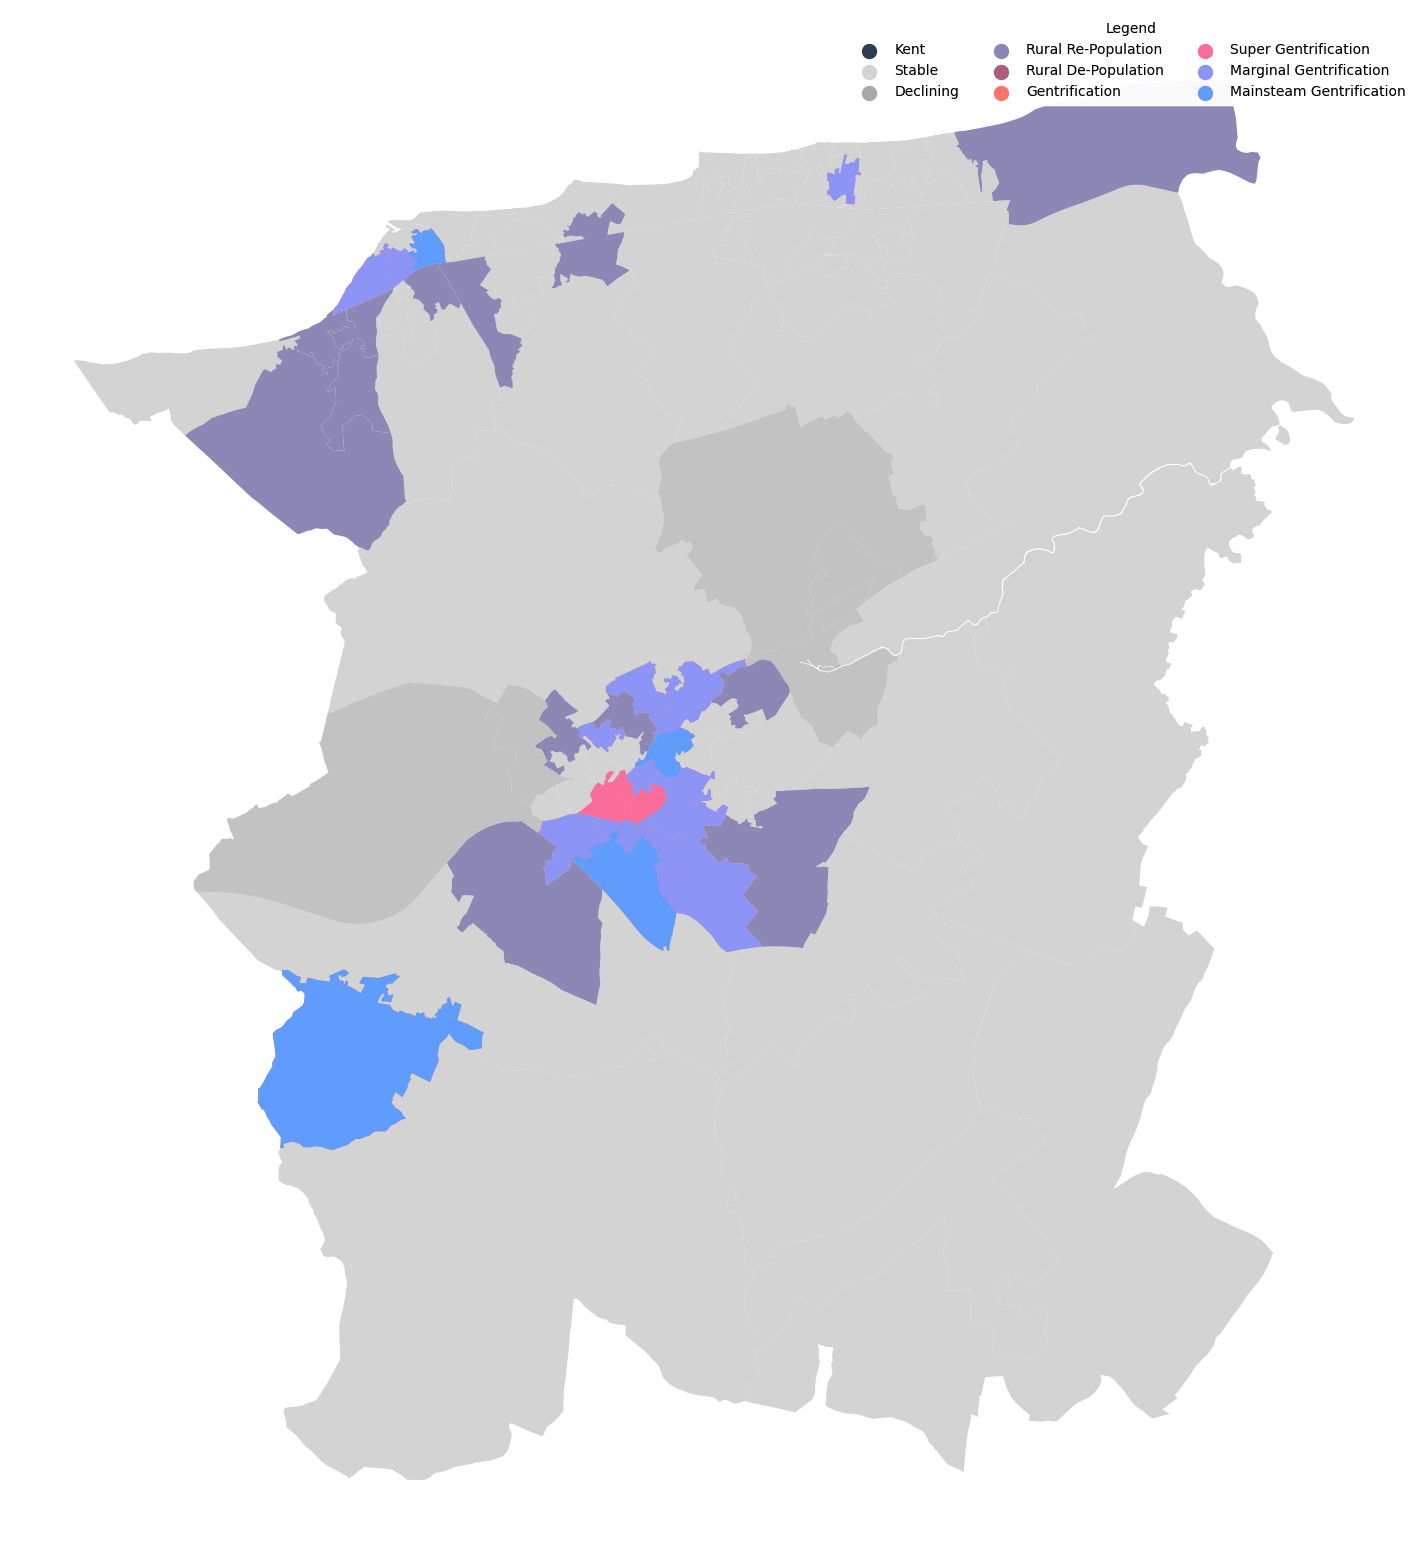

In [116]:
# Canterbury 

cant = level1_level2_level3[level1_level2_level3['LSOA11NM'].str.contains("Canterbury")]
#cant_level2 = cluster_2_yeoJohnson_zscore_gdf[cluster_2_yeoJohnson_zscore_gdf['LSOA11NM'].str.contains("Sevenoaks")]

# Visulise previous data on gentrification

# Filter by status, allowing control over colors of map
stb = cant.loc[cant['Level1Cat'] == "STB"]
dec = cant.loc[cant['Level1Cat'] == "DEC"]

clus1 = cant.loc[cant['Level2Cat'] == "cluster1"]
clus2 = cant.loc[cant['Level2Cat'] == "cluster2"]
clus3 = cant.loc[cant['Level2Cat'] == "cluster3"]

clus4 = cant.loc[cant['Level3Cat'] == "cluster4"]
clus5= cant.loc[cant['Level3Cat'] == "cluster5"]
clus6= cant.loc[cant['Level3Cat'] == "cluster6"]

# Plot shapfiles

# Set axes
fig, ax = plt.subplots(figsize=(20,20))
ax.set_aspect('equal')
ax.set_facecolor("white")


ax.xaxis.set_visible(False) 
ax.yaxis.set_visible(False) 


stb.plot(ax=ax, facecolor="lightgrey")
dec.plot(ax=ax, facecolor="darkgrey", alpha=0.7)

clus1.plot(ax=ax, facecolor="#8B88B6")
clus2.plot(ax=ax, facecolor="#AA5E79")
clus3.plot(ax=ax, facecolor="#fd746c")

clus4.plot(ax=ax, facecolor="#fb6e9c")
clus5.plot(ax=ax, facecolor="#8c94f6")
clus6.plot(ax=ax, facecolor="#5f9cfb")

# Add basemap
#ctx.add_basemap(ax, crs=kent_2018.crs.to_string(), source=ctx.providers.CartoDB.Positron)

# # Add scale bar
# # Points on the sane lattitude, one longitude apart
# points = gpd.GeoSeries([Point(51.5072, 0.1276), Point(52.5072, 0.1276)], crs=4326)
# # Calculate difference
# distance_meters = points[0].distance(points[1])
# # Plot
# ax.add_artist(ScaleBar(distance_meters, color="dimgray", location="lower right")) 

# # Add north arrow

# Add legend
l1 = plt.scatter([],[], s=100, marker='o', color='#2c3e50')
l2 = plt.scatter([],[], s=100, marker='o', color='lightgrey')
l3 = plt.scatter([],[], s=100, marker='o', color='darkgrey')
l4 = plt.scatter([],[], s=100, marker='o', color='#8B88B6')
l5 = plt.scatter([],[], s=100, marker='o', color='#AA5E79')
l6 = plt.scatter([],[], s=100, marker='o', color='#fd746c')
l7 = plt.scatter([],[], s=100, marker='o', color='#fb6e9c')
l8 = plt.scatter([],[], s=100, marker='o', color='#8c94f6')
l9 = plt.scatter([],[], s=100, marker='o', color='#5f9cfb')

labels = ["Kent", "Stable","Declining", "Rural Re-Population", "Rural De-Population", "Gentrification", "Super Gentrification", "Marginal Gentrification","Mainsteam Gentrification"]
legend = ax.legend([l1, l2,l3, l4, l5, l6, l7, l8, l9], labels, loc="upper right", title='Legend', facecolor="white", edgecolor="white", ncol=3)    
ax.add_artist(legend)
   
plt.savefig(os.path.join("Figures", 'map_cant_cluster2.png'), transparent=True, dpi=300)

# Show map
plt.show()

/opt/conda/envs/sds2021/lib/python3.9/site-packages/geopandas/plotting.py:678: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(
/opt/conda/envs/sds2021/lib/python3.9/site-packages/geopandas/plotting.py:678: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(
/opt/conda/envs/sds2021/lib/python3.9/site-packages/geopandas/plotting.py:678: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(


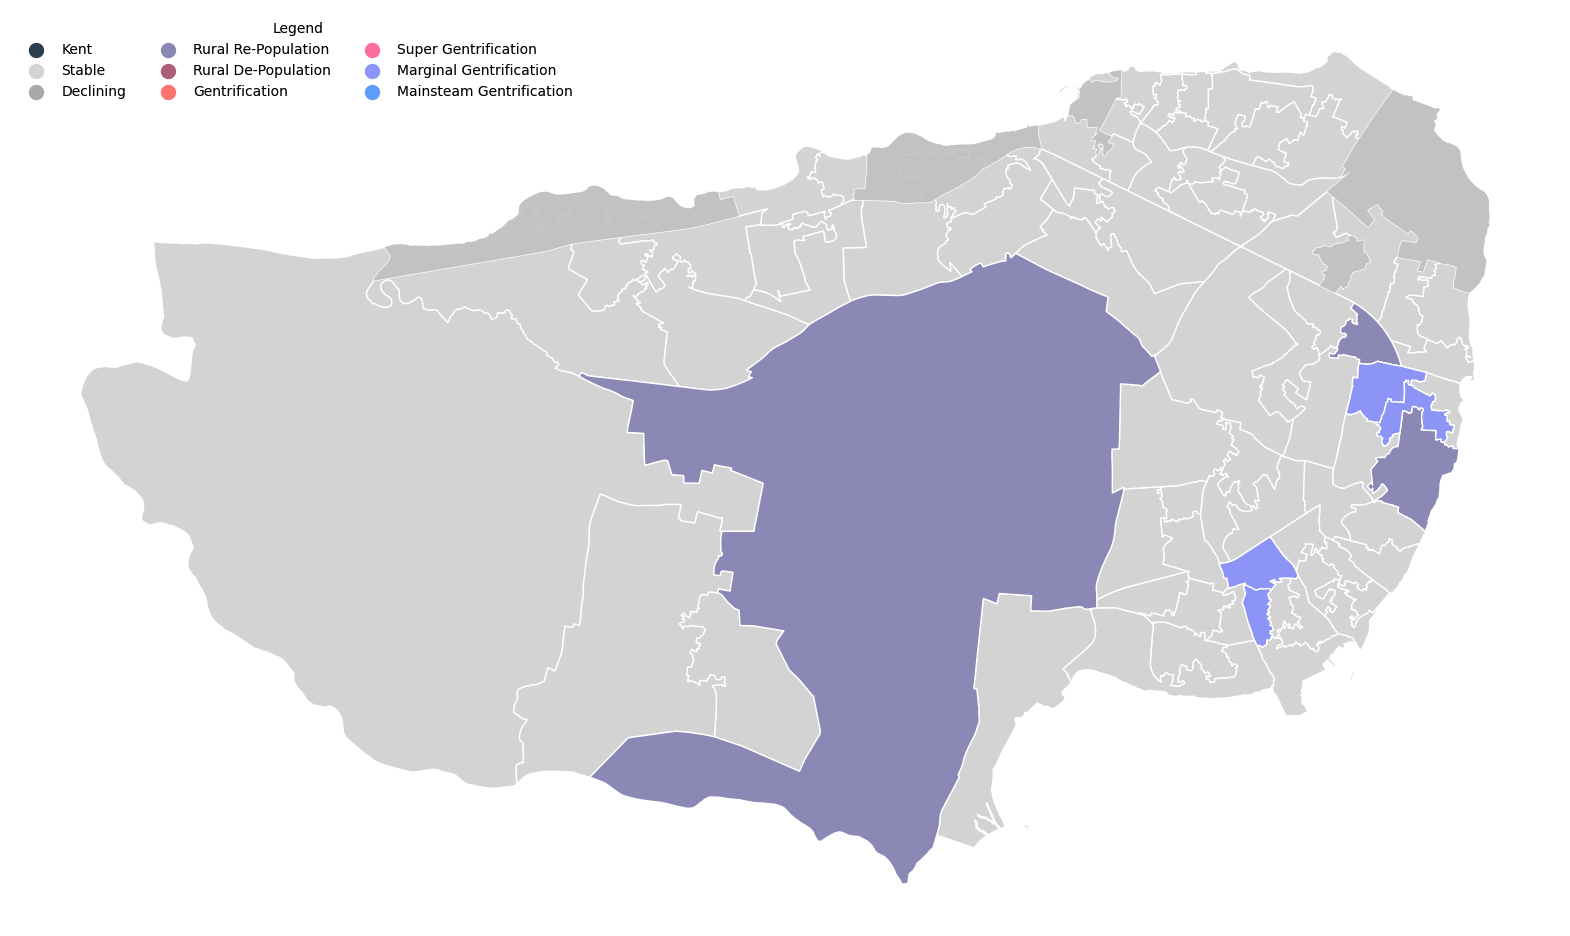

In [148]:
# Canterbury 

cant = level1_level2_level3[level1_level2_level3['LSOA11NM'].str.contains("Thanet")]
#cant_level2 = cluster_2_yeoJohnson_zscore_gdf[cluster_2_yeoJohnson_zscore_gdf['LSOA11NM'].str.contains("Sevenoaks")]

# Visulise previous data on gentrification

# Filter by status, allowing control over colors of map
stb = cant.loc[cant['Level1Cat'] == "STB"]
dec = cant.loc[cant['Level1Cat'] == "DEC"]

clus1 = cant.loc[cant['Level2Cat'] == "cluster1"]
clus2 = cant.loc[cant['Level2Cat'] == "cluster2"]
clus3 = cant.loc[cant['Level2Cat'] == "cluster3"]

clus4 = cant.loc[cant['Level3Cat'] == "cluster4"]
clus5= cant.loc[cant['Level3Cat'] == "cluster5"]
clus6= cant.loc[cant['Level3Cat'] == "cluster6"]

# Plot shapfiles

# Set axes
fig, ax = plt.subplots(figsize=(20,20))
ax.set_aspect('equal')
ax.set_facecolor("white")


ax.xaxis.set_visible(False) 
ax.yaxis.set_visible(False) 


stb.plot(ax=ax, facecolor="lightgrey", edgecolor="white")
dec.plot(ax=ax, facecolor="darkgrey", alpha=0.7)

clus1.plot(ax=ax, facecolor="#8B88B6", edgecolor="white")
clus2.plot(ax=ax, facecolor="#AA5E79", edgecolor="white")
clus3.plot(ax=ax, facecolor="#fd746c", edgecolor="white")

clus4.plot(ax=ax, facecolor="#fb6e9c", edgecolor="white")
clus5.plot(ax=ax, facecolor="#8c94f6", edgecolor="white")
clus6.plot(ax=ax, facecolor="#5f9cfb", edgecolor="white")

# Add basemap
#ctx.add_basemap(ax, crs=kent_2018.crs.to_string(), source=ctx.providers.CartoDB.Positron)

# # Add scale bar
# # Points on the sane lattitude, one longitude apart
# points = gpd.GeoSeries([Point(51.5072, 0.1276), Point(52.5072, 0.1276)], crs=4326)
# # Calculate difference
# distance_meters = points[0].distance(points[1])
# # Plot
# ax.add_artist(ScaleBar(distance_meters, color="dimgray", location="lower right")) 

# # Add north arrow

# Add legend
l1 = plt.scatter([],[], s=100, marker='o', color='#2c3e50')
l2 = plt.scatter([],[], s=100, marker='o', color='lightgrey')
l3 = plt.scatter([],[], s=100, marker='o', color='darkgrey')
l4 = plt.scatter([],[], s=100, marker='o', color='#8B88B6')
l5 = plt.scatter([],[], s=100, marker='o', color='#AA5E79')
l6 = plt.scatter([],[], s=100, marker='o', color='#fd746c')
l7 = plt.scatter([],[], s=100, marker='o', color='#fb6e9c')
l8 = plt.scatter([],[], s=100, marker='o', color='#8c94f6')
l9 = plt.scatter([],[], s=100, marker='o', color='#5f9cfb')

labels = ["Kent", "Stable","Declining", "Rural Re-Population", "Rural De-Population", "Gentrification", "Super Gentrification", "Marginal Gentrification","Mainsteam Gentrification"]
legend = ax.legend([l1, l2,l3, l4, l5, l6, l7, l8, l9], labels, loc="upper left", title='Legend', facecolor="white", edgecolor="white", ncol=3)    
ax.add_artist(legend)
   
plt.savefig(os.path.join("Figures", 'map_thanet_cluster2.png'), transparent=True, dpi=300)

# Show map
plt.show()